<a href="https://colab.research.google.com/github/reflectormensah/Financial-Engineering-Data-Science/blob/main/vecm_%26_cointegration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install YahooFinancials
!pip install arch
!pip install pmdarima
!pip install copulas

     |████████████████████████████████| 63 kB 836 kB/s 
     |████████████████████████████████| 6.4 MB 11.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
  Created wheel for YahooFinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15192 sha256=e871498d98d2d06b22520005a7ab5a682efbeddaaa7363453df5a5265263bcd1
  Stored in directory: /root/.cache/pip/wheels/4

In [ ]:
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import statsmodels.api as sm
import pandas_datareader as pdr
import arch
import pmdarima
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from scipy.stats import kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
from random import seed
from random import gauss
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

# 1. Importing Gold ETF, Equity ETF and Bitcoin

In [ ]:
start_date = "2020-04-01"
end_date = "2020-12-31"

# Step 1 Source VEU(FTSE ETF), BAR(Gold ETF) and Bitcoin price data
data_etf = yf.download("BAR VEU BTC-USD", start=start_date, end=end_date).reset_index()
data_etf["Date"] = [ ele.date() for ele in data_etf["Date"] ]
data_etf = data_etf.set_index("Date")
data_etf = data_etf[["Date", "Adj Close"]]
data_etf.columns = [ x.replace("","") for x in data_etf.columns.get_level_values(1) ]
data_etf = data_etf.reset_index()


# Data for the months of April to December, 2020
gold_etf= yf.download('BAR',
                      start=start_date,
                      end=end_date,
                      interval='1d')

equity_etf = yf.download('VEU',
                      start=start_date,
                      end=end_date,
                      interval='1d')
bitcoin = yf.download('BTC-USD',
                      start=start_date,
                      end=end_date,
                      interval='1d')


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# 2. Daily Returns of gold ETF, equity ETF and Bitcoin

In [ ]:
equity_etf['Returns'] = 100*(equity_etf['Adj Close'].pct_change())
gold_etf['Returns'] = 100*(gold_etf['Adj Close'].pct_change())
bitcoin['Returns'] = 100*(bitcoin['Adj Close'].pct_change())

gold_etf['Log_Return'] = np.log(gold_etf['Adj Close']).diff().mul(100)
equity_etf['Log_Return'] = np.log(equity_etf['Adj Close']).diff().mul(100)
bitcoin['Log_Return'] = np.log(bitcoin['Adj Close']).diff().mul(100)

gold_etf = gold_etf.dropna()
equity_etf = equity_etf.dropna()
bitcoin = bitcoin.dropna()

# 3. Data Summary

In [ ]:
from scipy.stats import kurtosis

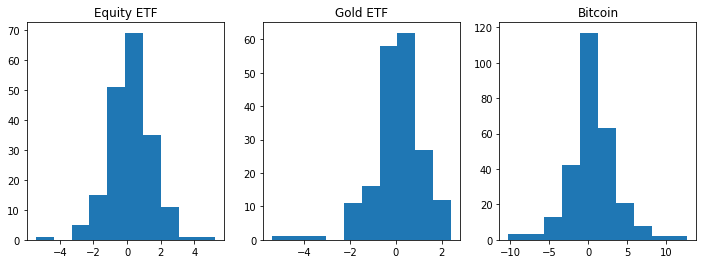

In [ ]:
# plot the distribution of returns
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(equity_etf['Returns'])
plt.title("Equity ETF");
plt.subplot(1,3,2)
plt.hist(gold_etf['Returns'])
plt.title("Gold ETF");
plt.subplot(1,3,3)
plt.hist(bitcoin['Returns'])
plt.title("Bitcoin");

In [ ]:
# Reference: https://medium.com/swlh/downside-risk-measures-9a013d03800d
# Make a skewness function
def skewness(r):
    '''
        ARGS:
            Series or Dataframe
        RETURNS:
            Float or a series data with the calculated skewness
    '''

    # Calculate the demeaned returns
    demeaned_r = r - r.mean()

    # Use the population standard deviation, ddof=0
    sigma_r = r.std(ddof=0)

    # Calculate the expectation of the demeaned returns raised to the third power
    exp = (demeaned_r**3).mean()

    # Calcualte the skew
    skew = exp/sigma_r**3
    return round(skew,2)

# Make a kurtosis function
def kurtosis(r):
    '''
        ARGS:
            Series or Dataframe
        RETURNS:
            Float or a series data with the calculated kurtosis
    '''

    # Calculate the demeaned returns
    demeaned_r = r - r.mean()

    # Use the population standard deviation, ddof=0
    sigma_r = r.std(ddof=0)

    # Calculate the expectation of the demeaned returns raised to the fourth power
    exp = (demeaned_r**4).mean()

    # Calcualte the skew
    kurt = exp/sigma_r**4
    return round(kurt,2)


In [ ]:
# Calculate skew and kurt for Gold ETF returns
gold_k = kurtosis(gold_etf['Returns'])
gold_s = skewness(gold_etf['Returns'])

equity_k = kurtosis(equity_etf['Returns'])
equity_s = skewness(equity_etf['Returns'])

bitcoin_k = kurtosis(bitcoin['Returns'])
bitcoin_s = skewness(bitcoin['Returns'])

stats = pd.DataFrame(np.array([["Gold ETF", gold_k, gold_s],["Equity ETF",equity_k,equity_s],["Bitcoin",bitcoin_k,bitcoin_s]]),
                     columns = ["Stock","Kurtosis","Skewness"])


#stats = pd.concat([np.array([gold_s, equity_s, bitcoin_s]), np.array([gold_k, equity_k, bitcoin_k])], axis=1)
#stats.columns = ["Skewness", "Kurtosis"]
stats

,Stock,Kurtosis,Skewness
0,Gold ETF,7.01,-1.08
1,Equity ETF,5.37,-0.21
2,Bitcoin,5.84,0.37


If the value of kurtosis is >3, the distribution has a sharp peak. All the three stocks have sharp peak according to kurtosis value.

If the value of kurtosis is <3, the distribution has a flat peak

If the value of kurtosis is =3, the distribution follows a normal distribution




## Outlier detection

We can use inter quartile range (IQR) for outlier detection.

The first quartile (Q1) is 25th percentile, Q2 is the median 50th percentile and Q3 is 75th percentile.

Interquartiel range is defined as IQR = Q3-Q1

Outliers are defined as less than Q1 - 1.5 IQR and grater than  Q3 + 1.5 IQR

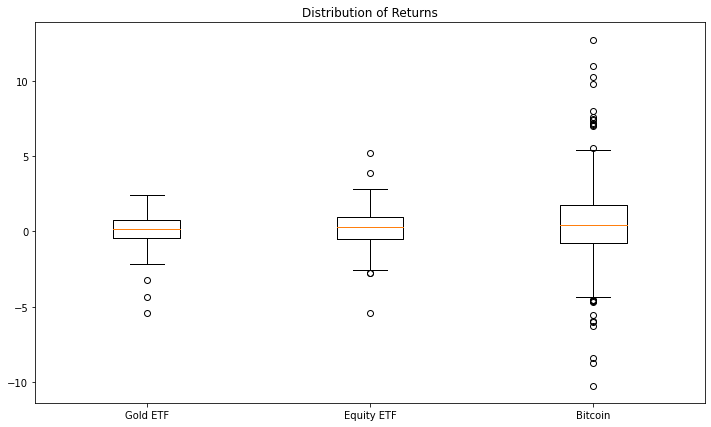

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title('Distribution of Returns')
dataset = [gold_etf['Returns'], equity_etf['Returns'], bitcoin['Returns']]
labels = ['Gold ETF', 'Equity ETF', 'Bitcoin']
ax.boxplot(dataset, labels=labels)
plt.show()

The data points outside Q1-1.5 IQR and Q3 + 1.5 IQR are shown above for each stock.


# 4. Data Comparision

Bitcoin has the most number of outliers followed by Equity ETF

In [ ]:
equity_bitcoin = pd.DataFrame({'bitcoin_returns':bitcoin["Returns"], 'equity_returns':equity_etf["Returns"]})
equity_bitcoin = equity_bitcoin.dropna()
equity_bitcoin.head()

,bitcoin_returns,equity_returns
Date,,
2020-04-02,2.828129,2.240299
2020-04-03,-0.886674,-1.967127
2020-04-06,7.077642,5.207020
2020-04-07,-1.311463,0.410425
2020-04-08,2.197254,1.033912


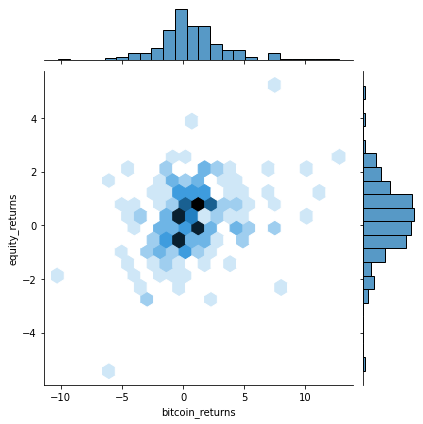

In [ ]:
sns.jointplot(data=equity_bitcoin, x="bitcoin_returns", y="equity_returns", kind="hex")

Using Vine Copula

In [ ]:
from copulas.multivariate import VineCopula
from copulas.visualization import compare_2d

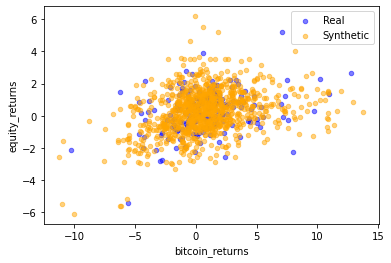

In [ ]:
dist = VineCopula('regular')
dist.fit(equity_bitcoin)

dist_samples = dist.sample(1000)

compare_2d(equity_bitcoin, dist_samples)

Category 1 Models

# 5. ARMA model
## Using Gold ETF

## ARMA model trained on Q2 and test on Q3


In [ ]:
gold_etf.head()

,Open,High,Low,Close,Adj Close,Volume,Returns,Log_Return
Date,,,,,,,,
2020-04-02,16.02,16.150000,15.960000,16.100000,16.100000,272500,1.577287,1.564977
2020-04-03,16.09,16.191000,16.040001,16.190001,16.190001,529600,0.559007,0.557450
2020-04-06,16.33,16.620001,16.290001,16.580000,16.580000,369900,2.408891,2.380334
2020-04-07,16.43,16.540001,16.334999,16.480000,16.480000,589700,-0.603139,-0.604965
2020-04-08,16.48,16.520000,16.350000,16.379999,16.379999,258200,-0.606798,-0.608647


In [ ]:
# Gold quarters
gold_etf_q2 = gold_etf[gold_etf.index.month.isin([4,5,6])]
gold_etf_q3 = gold_etf[gold_etf.index.month.isin([7,8,9])]
gold_etf_q4 = gold_etf[gold_etf.index.month.isin([10,11,12])]

# Equity ETF and Bitcoin quarters

equity_etf_q2 = equity_etf[equity_etf.index.month.isin([4,5,6])]
equity_etf_q3 = equity_etf[equity_etf.index.month.isin([7,8,9])]
equity_etf_q4 = equity_etf[equity_etf.index.month.isin([10,11,12])]

bitcoin_q2 = bitcoin[bitcoin.index.month.isin([4,5,6])]
bitcoin_q3 = bitcoin[bitcoin.index.month.isin([7,8,9])]
bitcoin_q4 = bitcoin[bitcoin.index.month.isin([10,11,12])]

# rename columns to avoid having same column names when combined
gold_etf_q2.rename(columns={'Returns':'gold_returns'}, inplace=True)
gold_etf_q2.rename(columns={'Log_Return':'gold_log_return'}, inplace=True)
equity_etf_q2.rename(columns={'Returns':'equity_returns'}, inplace=True)
equity_etf_q2.rename(columns={'Log_Return':'equity_log_return'}, inplace=True)
bitcoin_q2.rename(columns={'Returns':'bitcoin_returns'}, inplace=True)
bitcoin_q2.rename(columns={'Log_Return':'bitcoin_log_return'}, inplace=True)

gold_etf_q3.rename(columns={'Returns':'gold_returns'}, inplace=True)
gold_etf_q3.rename(columns={'Log_Return':'gold_log_return'}, inplace=True)
equity_etf_q3.rename(columns={'Returns':'equity_returns'}, inplace=True)
equity_etf_q3.rename(columns={'Log_Return':'equity_log_return'}, inplace=True)
bitcoin_q3.rename(columns={'Returns':'bitcoin_returns'}, inplace=True)
bitcoin_q3.rename(columns={'Log_Return':'bitcoin_log_return'}, inplace=True)

gold_etf_q4.rename(columns={'Returns':'gold_returns'}, inplace=True)
gold_etf_q4.rename(columns={'Log_Return':'gold_log_return'}, inplace=True)
equity_etf_q4.rename(columns={'Returns':'equity_returns'}, inplace=True)
equity_etf_q4.rename(columns={'Log_Return':'equity_log_return'}, inplace=True)
bitcoin_q4.rename(columns={'Returns':'bitcoin_returns'}, inplace=True)
bitcoin_q4.rename(columns={'Log_Return':'bitcoin_log_return'}, inplace=True)


In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
gold_etf_q2.index = pd.to_datetime(gold_etf_q2.index)
gold_etf_q3.index = pd.to_datetime(gold_etf_q3.index)
gold_etf_q4.index = pd.to_datetime(gold_etf_q4.index)

equity_etf_q2.index = pd.to_datetime(equity_etf_q2.index)
equity_etf_q3.index = pd.to_datetime(equity_etf_q3.index)
equity_etf_q4.index = pd.to_datetime(equity_etf_q4.index)

bitcoin_q2.index = pd.to_datetime(bitcoin_q2.index)
bitcoin_q3.index = pd.to_datetime(bitcoin_q3.index)
bitcoin_q4.index = pd.to_datetime(bitcoin_q4.index)

In [ ]:
# plot correlgram
# reference: https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/

def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    #stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)


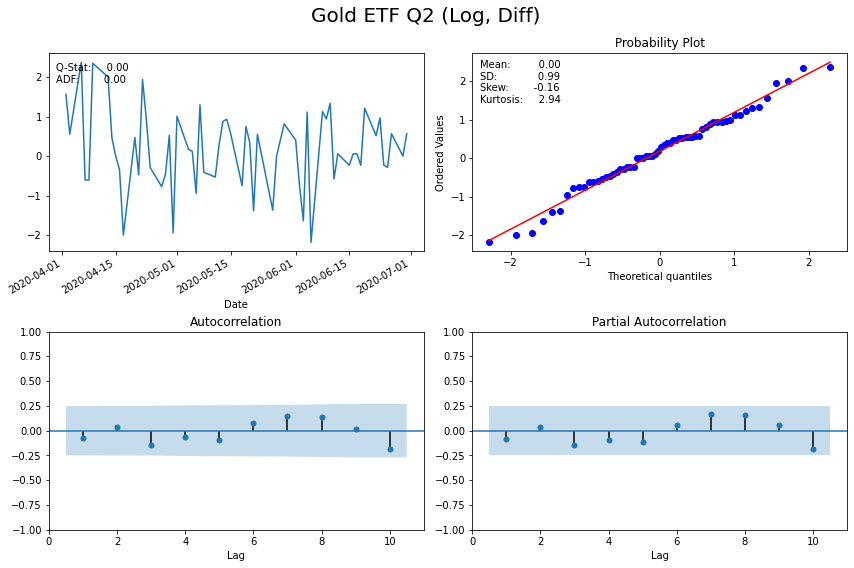

In [ ]:
# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(gold_etf_q2['gold_log_return'], lags=10, title='Gold ETF Q2 (Log, Diff)')

In [ ]:
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6),sharex=True)
#ax1.plot(gold_etf_q2['gold_log_return'])
#ax1.set_title('Original Series')
#ax2.plot(gold_etf_q2['gold_log_return'].diff()); ax1.set_title('1st Order Differencing')
#fig, ax = plt.subplots(1,1, figsize=(12,6),sharex=True)
#ax.plot(gold_etf_q2['Returns'])
#ax.set_title('Original Series')

In [ ]:
#plot_acf(gold_etf_q2['gold_log_return']);
#plot_pacf(gold_etf_q2['gold_log_return']);

In [ ]:
### test for stationarity
def stn_test(df):
  X = df.dropna().values
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
# Augmented Dickey-Fuller test
ad_fuller_q2 = stn_test(gold_etf_q2['gold_log_return'])

ADF Statistic: -8.434177
p-value: 0.000000
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593


From the ADF test, we can say that the gold quarter 2 returns are stationary. The p value < 0.05. Hence, we can reject the null hypothesis that the series is non-stationary. The Q2 returns don't need differencing.

The ACF and PACF plots show sinusoidal pattern. However, this looks like random noise.


### Trying different ARIMA models

We tried different ARIMA models such as ARIMA(1,0,1), ARIMA(1,1,1), ARIMA(1,1,0). We look at the p-values of the coefficients of the ARIMA models and select ARIMA(1,1,0) which has p values < 0.05.

In [ ]:
model_arma_q2 = ARIMA(gold_etf_q2['gold_log_return'].values, order=(1,1,0)).fit()
print(model_arma_q2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   62
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -98.455
Date:                Tue, 08 Feb 2022   AIC                            200.910
Time:                        17:33:51   BIC                            205.132
Sample:                             0   HQIC                           202.565
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5465      0.103     -5.288      0.000      -0.749      -0.344
sigma2         1.4686      0.348      4.222      0.000       0.787       2.150
Ljung-Box (L1) (Q):                   1.37   Jarque-

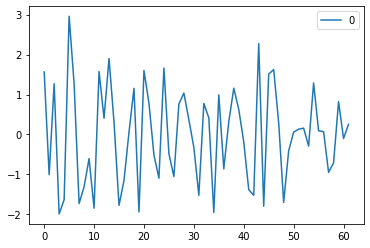

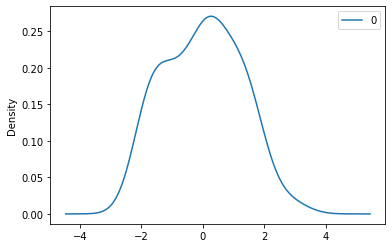

               0
count  62.000000
mean   -0.004677
std     1.230346
min    -1.989069
25%    -1.042399
50%     0.081134
75%     0.949434
max     2.959692


In [ ]:
# line plot of residuals
arma_residuals_q2 = pd.DataFrame(model_arma_q2.resid)
arma_residuals_q2.plot()
plt.show();

# density plot of residuals
arma_residuals_q2.plot(kind='kde')
plt.show()

print(arma_residuals_q2.describe())

The mean of the residuals is Gaussian and centered around 0.0

### Forecast of ARIMA model trained on Gold Q2 on Gold Q3

In [ ]:
# Forecast
arima_q3_fc = model_arma_q2.forecast(len(gold_etf_q3['gold_log_return']))  # 95% conf

# evaluate forecasts
arima_q2q3_rmse = np.sqrt(mean_squared_error(gold_etf_q3['gold_log_return'].values, arima_q3_fc))
print('Test RMSE: %.3f' % arima_q2q3_rmse)

Test RMSE: 1.278


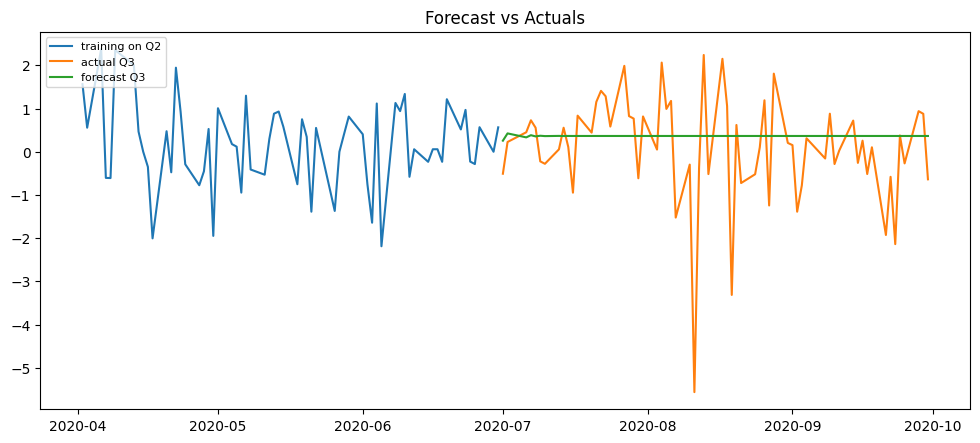

In [ ]:
# Make as pandas series
arima_q3_fc_series = pd.Series(arima_q3_fc, index=gold_etf_q3.index)
#arima_q3_lower_series = pd.Series(arima_q3_conf[:, 0], index=gold_etf_q3.index)
#arima_q3_upper_series = pd.Series(arima_q3_conf[:, 1], index=gold_etf_q3.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(gold_etf_q2['gold_log_return'], label='training on Q2') #This is the training data: Q2
plt.plot(gold_etf_q3['gold_log_return'], label='actual Q3') #This is the test data : Q3
plt.plot(arima_q3_fc_series, label='forecast Q3') # This is the forecasted Q3 from the ARIMA model
#plt.fill_between(arima_q3_lower_series.index, arima_q3_lower_series, arima_q3_upper_series,
#                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# ARIMA model trained on Q2 and the mean squared error from Q3
print('ARIMA(1,1,0) MSE:', 1.278)
#print('ARIMA(1,1,1) MSE:', 1.252)
#print('ARIMA(3,1,1) MSE:', 1.250)
#print('ARIMA(5,1,5) MSE:', 1.310)

ARIMA(1,1,0) MSE: 1.278


The ARIMA(1,1,0) model gives p-values < 0.05 for the coefficients and the root means squared error is not very different from the other models.

The model captures the mean but not the variance.

## ARIMA trained on Q3 and tested on Q4

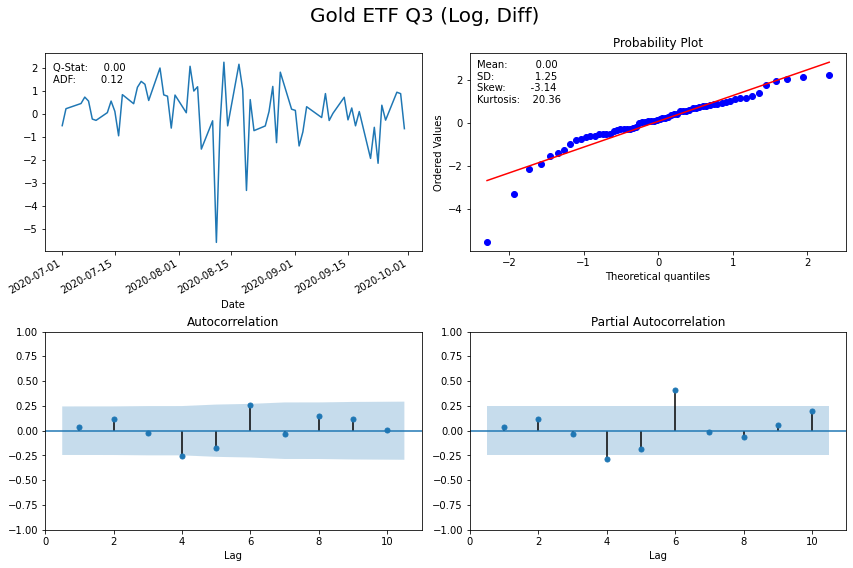

In [ ]:
plot_correlogram(gold_etf_q3['gold_log_return'], lags=10, title='Gold ETF Q3 (Log, Diff)')

In [ ]:
stn_test(gold_etf_q3['gold_log_return'])
stn_test(gold_etf_q3['gold_log_return'].diff())

ADF Statistic: -2.491235
p-value: 0.117621
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594
ADF Statistic: -7.965018
p-value: 0.000000
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


Based on the ADF test, Gold Q3 is not stationary because the p-value is >0.05.
The p-value of the difference Q3 is < 0.05 which tells us that it is stationary

Based on ACF and PACF, they are both sinusoidal.

In [ ]:
#model_arma_q3 = ARIMA(gold_etf_q3['Log_Return'].diff().values, order=(4,1,6)).fit()
model_arma_q3 = ARIMA(gold_etf_q3['gold_log_return'].values, order=(3,1,3)).fit()
# summary of fit model
print(model_arma_q3.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   64
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -100.071
Date:                Tue, 08 Feb 2022   AIC                            214.143
Time:                        17:33:55   BIC                            229.145
Sample:                             0   HQIC                           220.043
                                 - 64                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1845      0.264     -0.700      0.484      -0.701       0.332
ar.L2         -0.4779      0.136     -3.519      0.000      -0.744      -0.212
ar.L3          0.1777      0.283      0.628      0.5

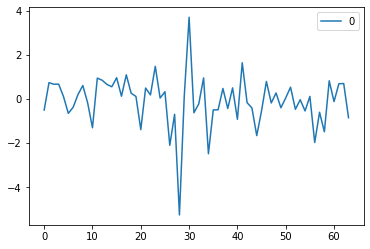

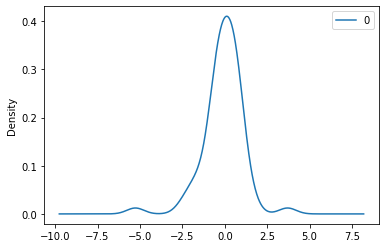

               0
count  64.000000
mean   -0.085649
std     1.165152
min    -5.267466
25%    -0.516376
50%     0.072771
75%     0.616244
max     3.701243


In [ ]:
# line plot of residuals
arma_residuals_q3 = pd.DataFrame(model_arma_q3.resid)
arma_residuals_q3.plot()
plt.show();

# density plot of residuals
arma_residuals_q3.plot(kind='kde')
plt.show()

print(arma_residuals_q3.describe())

The mean of the residuals is Gaussian and centered around 0.0

### Forecast of ARIMA model trained on Gold Q3 on Gold Q4

In [ ]:
# Forecast
arima_q4_fc = model_arma_q3.forecast(len(gold_etf_q4['gold_log_return']))

# evaluate forecasts
arima_q3q4_rmse = np.sqrt(mean_squared_error(gold_etf_q4['gold_log_return'].values, arima_q4_fc))
print('Test RMSE: %.3f' % arima_q3q4_rmse)

Test RMSE: 1.028


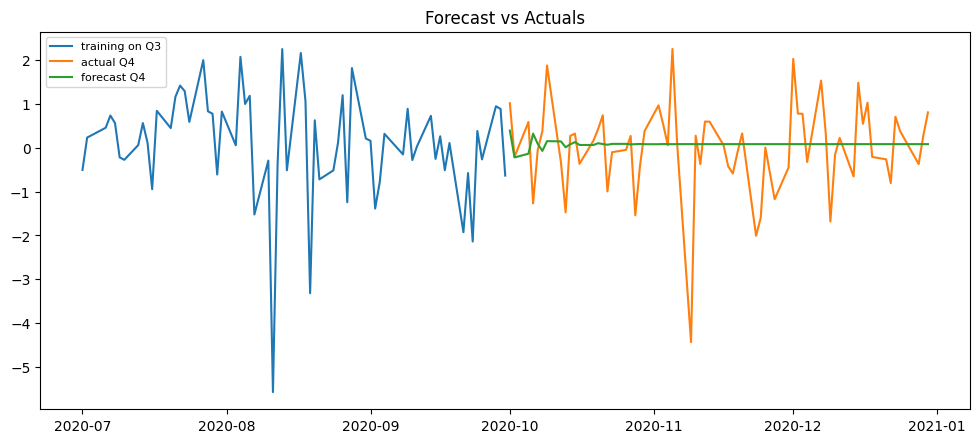

In [ ]:
# Make as pandas series
arima_q4_fc_series = pd.Series(arima_q4_fc, index=gold_etf_q4.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(gold_etf_q3['gold_log_return'], label='training on Q3') #This is the training data: Q3
plt.plot(gold_etf_q4['gold_log_return'], label='actual Q4') #This is the test data : Q4
plt.plot(arima_q4_fc_series, label='forecast Q4') # This is the forecasted Q4 from the ARIMA model
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# ARIMA model trained on Q2 and the mean squared error from Q3
#print('ARIMA(4,1,6) MSE:', 1.167)
#print('ARIMA(1,1,1) MSE:', 1.026)
print('ARIMA(3,1,3) MSE:', 1.028)
#print('ARIMA(4,1,4) MSE:', 1.129)

ARIMA(3,1,3) MSE: 1.028


ARIMA(3,1,3) gives a low root meas squred error on Q4 and several p-values of the coefficients are not <0.05.

So we choose ARIMA(1,1,0) as the best model under ARMA Strategy.
The mean value of Q3 is predicted accurated but the variance is not captured by this model.

#GARCH model

## GARCH trained on Q2 and tested on Q3



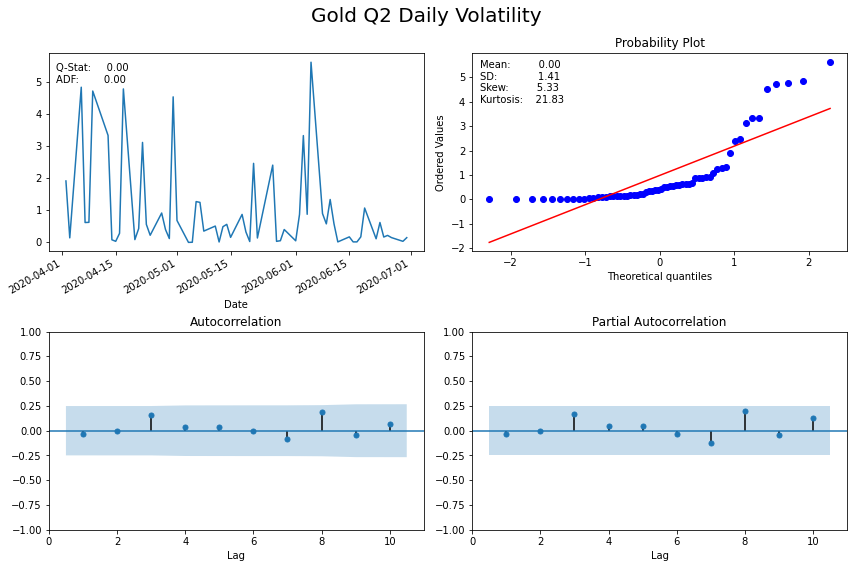

In [ ]:
plot_correlogram(gold_etf_q2['gold_log_return'].sub(gold_etf_q2['gold_log_return'].mean()).pow(2), lags=10, title='Gold Q2 Daily Volatility')

In [ ]:
# Calculate daily std of returns
std_daily = gold_etf_q2['gold_log_return'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 1.0%

Monthly volatility: 4.57%

Annual volatility: 15.85%


In [ ]:
#garch_q2 = arch_model(gold_etf_q2['gold_log_return'].values, mean="Zero", vol='GARCH', p=1, q=0, dist="skewt")
garch_q2 = arch_model(gold_etf_q2['gold_log_return'], mean = 'Zero', vol='GARCH', p=1, q=1, dist = 'normal')
model_garch_q2 = garch_q2.fit(disp = 'off')
print(model_garch_q2.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:        gold_log_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.016
Vol Model:                      GARCH   Log-Likelihood:               -85.8692
Distribution:                  Normal   AIC:                           177.738
Method:            Maximum Likelihood   BIC:                           184.120
                                        No. Observations:                   62
Date:                Tue, Feb 08 2022   Df Residuals:                       62
Time:                        17:33:59   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega      1.0132e-08  5.345e-02  1.896e-07      1.000 [ -0.105,  0.10

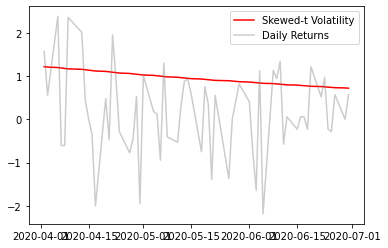

In [ ]:
# Plot model fitting results
plt.plot(model_garch_q2.conditional_volatility, color = 'red', label = 'Skewed-t Volatility')
plt.plot(gold_etf_q2['gold_log_return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show();

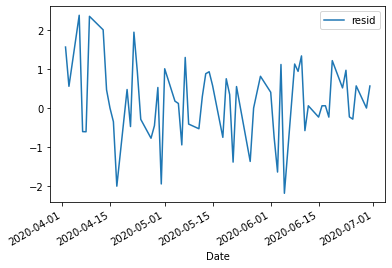

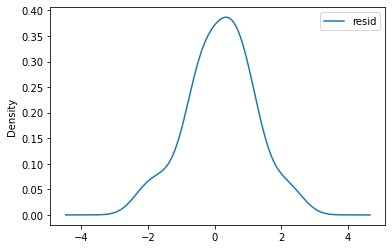

           resid
count  62.000000
mean    0.181697
std     0.998148
min    -2.187500
25%    -0.441330
50%     0.236128
75%     0.864521
max     2.380334


In [ ]:
# line plot of residuals
garch_residuals_q2 = pd.DataFrame(model_garch_q2.resid)
garch_residuals_q2.plot()
plt.show();

# density plot of residuals
garch_residuals_q2.plot(kind='kde')
plt.show()

print(garch_residuals_q2.describe())

Forecasting the garch q2 on q3

In [ ]:
# Forecast
garch_q3_fc = model_garch_q2.forecast(horizon=len(gold_etf_q3['gold_log_return']), reindex=False)
garch_q3_fc_mean = garch_q3_fc.mean.values[0]
garch_q3_fc_var = garch_q3_fc.residual_variance.values[0]
#garch_q3_fc_var = garch_q3_fc.variance.values[0]

# evaluate forecasts
garch_q2q3_rmse = np.sqrt(mean_squared_error(gold_etf_q3['gold_log_return'].values, garch_q3_fc.mean.values[0]))
print('Test RMSE: %.3f' % garch_q2q3_rmse)

Test RMSE: 1.251


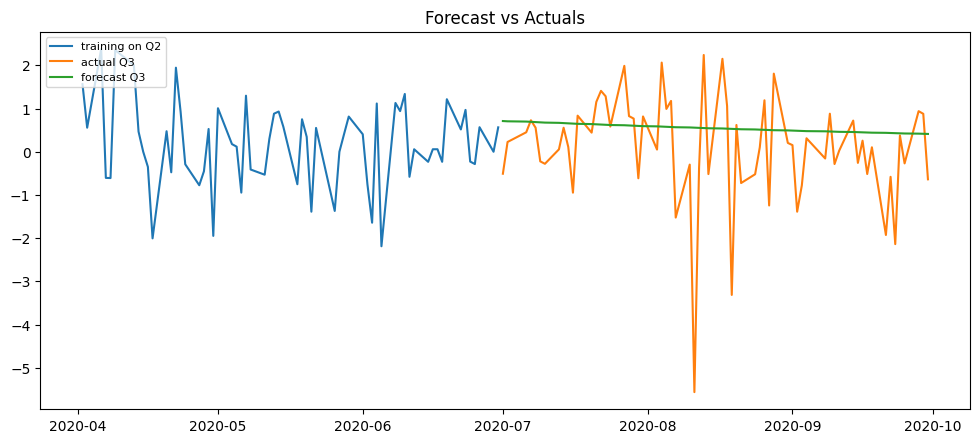

In [ ]:
# Make as pandas series
#garch_q3_fc_series = pd.Series(garch_q3_fc_mean, index=gold_etf_q3.index)
garch_q3_fc_series = pd.Series(np.sqrt(garch_q3_fc_var), index=gold_etf_q3.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(gold_etf_q2['gold_log_return'], label='training on Q2') #This is the training data: Q2
plt.plot(gold_etf_q3['gold_log_return'], label='actual Q3') #This is the test data : Q3
plt.plot(garch_q3_fc_series, label='forecast Q3') # This is the forecasted Q3 from the GARCH model

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The volatility model does not fit the returns on both the training data and the test data


## GARCH trained on Q3 and tested on Q4

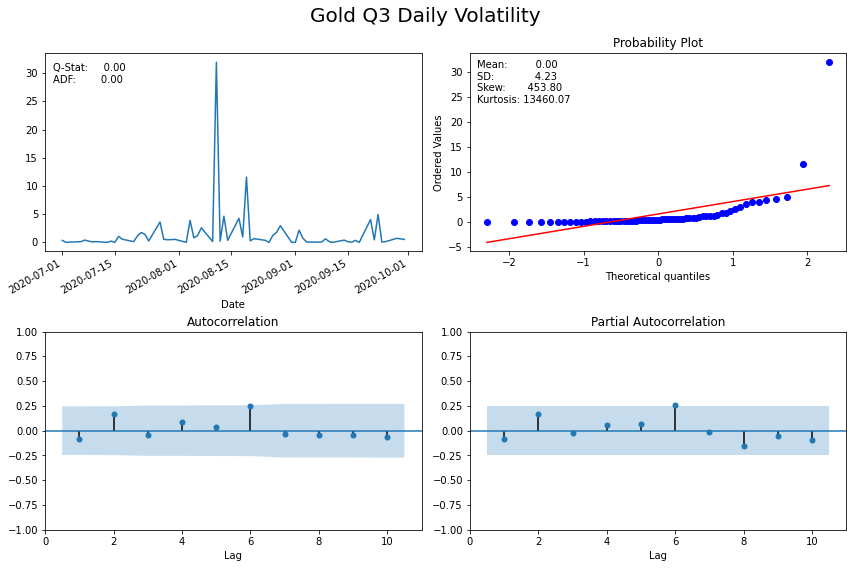

In [ ]:
plot_correlogram(gold_etf_q3['gold_log_return'].sub(gold_etf_q3['gold_log_return'].mean()).pow(2), lags=10, title='Gold Q3 Daily Volatility')

In [ ]:
garch_q3 = arch_model(gold_etf_q3['gold_log_return'], mean = 'Zero', vol='GARCH', p=2, q=2, dist = 'skewt')
model_garch_q3 = garch_q3.fit(disp = 'off')
print(model_garch_q3.summary())
#model_garch_q3 = arch_model(gold_etf_q3['Log_Return'].values, mean="Zero", vol='GARCH', p=3, q=3).fit()
# summary of fit model
#print(model_garch_q3.summary())

                             Zero Mean - GARCH Model Results                             
Dep. Variable:                   gold_log_return   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.016
Vol Model:                                 GARCH   Log-Likelihood:               -92.3046
Distribution:      Standardized Skew Student's t   AIC:                           198.609
Method:                       Maximum Likelihood   BIC:                           213.721
                                                   No. Observations:                   64
Date:                           Tue, Feb 08 2022   Df Residuals:                       64
Time:                                   17:34:03   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------------------------

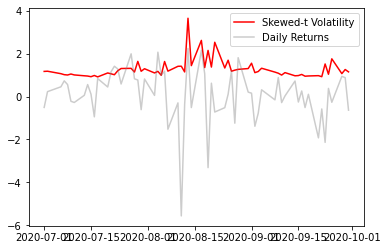

In [ ]:
# Plot model fitting results
plt.plot(model_garch_q3.conditional_volatility, color = 'red', label = 'Skewed-t Volatility')
plt.plot(gold_etf_q3['gold_log_return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show();

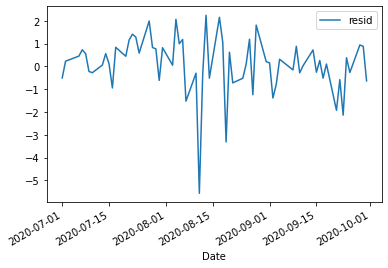

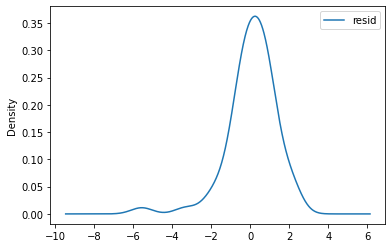

           resid
count  64.000000
mean    0.086518
std     1.257859
min    -5.564080
25%    -0.510197
50%     0.178890
75%     0.828171
max     2.240262


In [ ]:
# line plot of residuals
garch_residuals_q3 = pd.DataFrame(model_garch_q3.resid)
garch_residuals_q3.plot()
plt.show();

# density plot of residuals
garch_residuals_q3.plot(kind='kde')
plt.show()

print(garch_residuals_q3.describe())

Forecasting from Q3 on Q4

In [ ]:
# Forecast
garch_q4_fc = model_garch_q3.forecast(horizon=len(gold_etf_q4['gold_log_return']), reindex=False)
garch_q4_fc_mean = garch_q4_fc.mean.values[0]
garch_q4_fc_var = garch_q4_fc.residual_variance.values[0]
#garch_q3_fc_var = garch_q3_fc.variance.values[0]

# evaluate forecasts
garch_q3q4_rmse = np.sqrt(mean_squared_error(gold_etf_q4['gold_log_return'].values, garch_q4_fc.mean.values[0]))
print('Test RMSE: %.3f' % garch_q3q4_rmse)

Test RMSE: 1.025


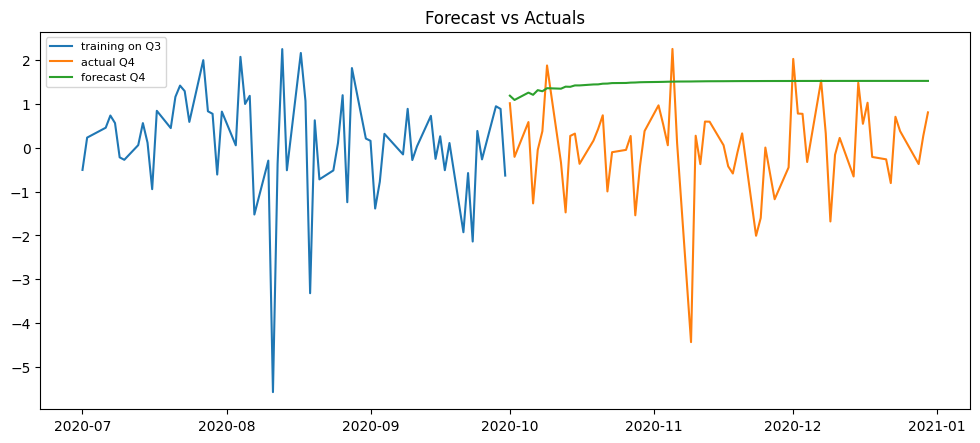

In [ ]:
# Make as pandas series
garch_q4_fc_series = pd.Series(np.sqrt(garch_q4_fc_var), index=gold_etf_q4.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(gold_etf_q3['gold_log_return'], label='training on Q3') #This is the training data: Q3
plt.plot(gold_etf_q4['gold_log_return'], label='actual Q4') #This is the test data : Q4
plt.plot(garch_q4_fc_series, label='forecast Q4') # This is the forecasted Q4 from the GARCH model

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The GARCH model trained on Q3 captures the volatility of Q3 but does not predict the volatilitiy of Q4

From the Garch models of Q2 and Q3, we have to choose GARCH model of Q2, which have a relatively parsimonous alpha value of 0.09(spiky market), other than other alpha values of greater than 1.
###GARCH Model Strategy
So for the strategy for GARCH model becomes Garch of Q2

###Category 2 Models


# 6. Using VAR Gold ETF and Equity ETF

In [ ]:
gold_equity_q2 = pd.concat([gold_etf_q2[['gold_returns', 'gold_log_return']], equity_etf_q2[['equity_returns', 'equity_log_return']]], axis=1).reindex(gold_etf_q2.index)
gold_equity_q3 = pd.concat([gold_etf_q3[['gold_returns', 'gold_log_return']], equity_etf_q3[['equity_returns', 'equity_log_return']]], axis=1).reindex(gold_etf_q3.index)
gold_equity_q4 = pd.concat([gold_etf_q4[['gold_returns', 'gold_log_return']], equity_etf_q4[['equity_returns', 'equity_log_return']]], axis=1).reindex(gold_etf_q4.index)

In [ ]:
gold_equity_q2.head()

,gold_returns,gold_log_return,equity_returns,equity_log_return
Date,,,,
2020-04-02,1.577287,1.564977,2.240299,2.215573
2020-04-03,0.559007,0.557450,-1.967127,-1.986732
2020-04-06,2.408891,2.380334,5.207020,5.075984
2020-04-07,-0.603139,-0.604965,0.410425,0.409585
2020-04-08,-0.606798,-0.608647,1.033912,1.028604


###VAR on Q2 to forecast Q3

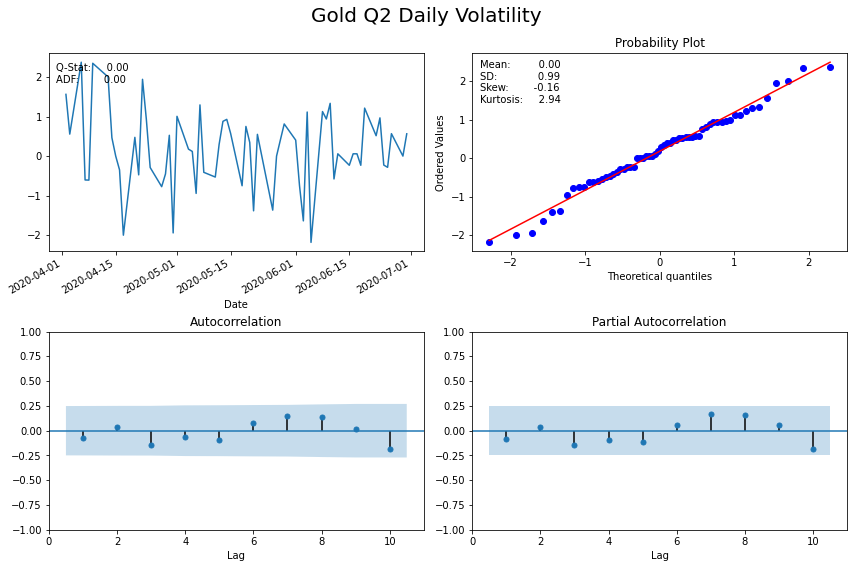

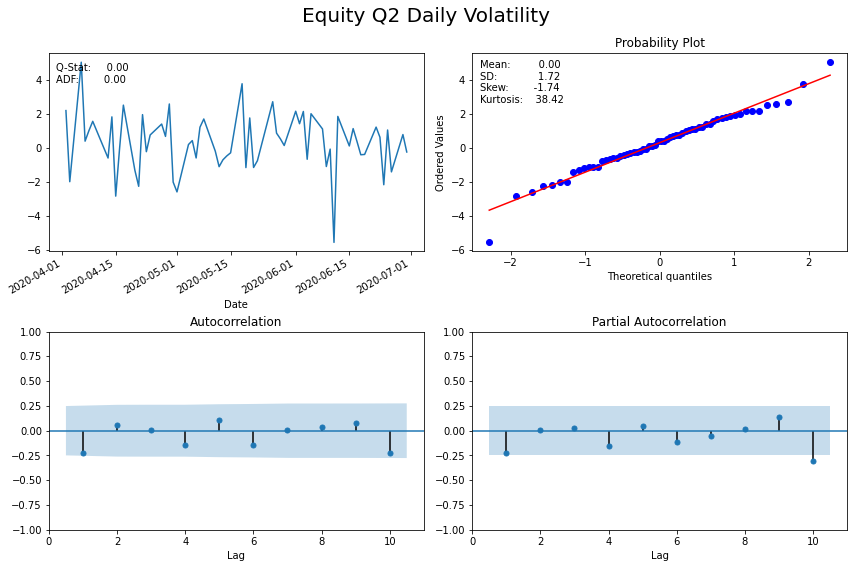

In [ ]:
# Visualizing the returns and log returns, log_returns(down)
plot_correlogram(gold_equity_q2['gold_log_return'], lags=10, title='Gold Q2 Daily Volatility')
plot_correlogram(gold_equity_q2['equity_log_return'], lags=10, title='Equity Q2 Daily Volatility')

In [ ]:
# Visualizing the returns and log returns, log_returns(down)
#fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
#for i, ax in enumerate(axes.flatten()):
#  gold_equity_train = gold_equity_q2[gold_equity_q2.columns[i]]
#  ax.plot(gold_equity_q2, color='red', linewidth=1)

#Plotting
#ax.set_title(gold_equity_q2.columns[i])
#ax.xaxis.set_ticks_position('none')
#ax.yaxis.set_ticks_position('none')
#ax.spines["top"].set_alpha(0)
#ax.tick_params(labelsize=6)
#plt.tight_layout()

In [ ]:
### test for stationarity
def stn_test(df):
  X = df.dropna().values
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
# cointegration test
import statsmodels.tsa.stattools as ts

def coint(df, col1, col2):
  x = df[col1]
  y = df[col2]
  co_integrate = ts.coint(x,y)
  print('p-value: ',co_integrate[1])
  if co_integrate[1] < 0.05:
    print(df.columns[1] +': Null hypothesis is false. Co-Integration exists')
  else:
    print(df.columns[1] + ': Null hypothesis is true. Co-Integration does not exist')
  #if (co_integrate[1] > co_integrate[2][2]) == True:
  #  print(df.columns[1] + ': Co-Integration does not exists at 10%')
  #else:
  #  print(df.columns[1] +': Co-Integration exists at 10%')

In [ ]:
coint(gold_equity_q2, 'gold_log_return', 'equity_log_return')

p-value:  2.0489678855789327e-12
gold_log_return: Null hypothesis is false. Co-Integration exists


In [ ]:
print('Testing stationarity in Gold etf q2')
stn_test(gold_equity_q2['gold_log_return'])
print('-------------------------------------')
print('Testing stationarity in Equity etf q2')
stn_test(gold_equity_q2['equity_log_return'])

Testing stationarity in Gold etf q2
ADF Statistic: -8.434177
p-value: 0.000000
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593
-------------------------------------
Testing stationarity in Equity etf q2
ADF Statistic: -9.759056
p-value: 0.000000
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593


The p-value is < 0.05 in both the cases. Hence we can reject the null hypothesis that the time series is not stationary.

No need to do differencing

In [ ]:
q2_varmodel = VAR(gold_equity_q2[['gold_log_return','equity_log_return']])
#q2_aic_var = q2_varmodel.select_order(maxlags=8)
#print(q2_aic_var.summary())
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = q2_varmodel.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  1.1669136075329152
BIC :  1.374540544992585
FPE :  3.212573860922916
HQIC:  1.24828455014174 

Lag Order = 2
AIC :  1.3028762348176752
BIC :  1.651933661854692
FPE :  3.6827180158151798
HQIC:  1.4394117836273261 

Lag Order = 3
AIC :  1.2077167415579457
BIC :  1.7006917282474385
FPE :  3.353358957116452
HQIC:  1.4001542106887448 

Lag Order = 4
AIC :  1.2089749158448129
BIC :  1.8484227467040464
FPE :  3.3670261383047473
HQIC:  1.4580527608125098 

Lag Order = 5
AIC :  1.3549090773596366
BIC :  2.1434551807343754
FPE :  3.914594977907959
HQIC:  1.661364963915406 

Lag Order = 6
AIC :  1.2047267323093678
BIC :  2.145068588722116
FPE :  3.3938605594693105
HQIC:  1.5692952813976893 

Lag Order = 7
AIC :  1.1550721448323977
BIC :  2.2499811549592
FPE :  3.265440370664781
HQIC:  1.5784823037321067 

Lag Order = 8
AIC :  1.2107933493603658
BIC :  2.463116637937872
FPE :  3.508041901154056
HQIC:  1.693765330877984 

Lag Order = 9
AIC :  1.2923967954039957
BIC :  2.7050589

We can see that equity log returns causes gold log returns with 7 lags.

In [ ]:
#from statsmodels.tsa.stattools import grangercausalitytests
#print('gold_log_return causes equity_log_return?\n')
#print('...........................................')
#test_1 = grangercausalitytests(gold_equity_q2[['gold_log_return', 'equity_log_return']], 10)

#second test
#print('...........................................')
#print('equity_log_return causes gold_log_return?\n')
#print('............................................')
#test_2 = grangercausalitytests(gold_equity_q2[['equity_log_return', 'gold_log_return']], 10)


In [ ]:
q2_varmodel = VAR(gold_equity_q2[['gold_log_return','equity_log_return']])
q2_varmodel_fitted = q2_varmodel.fit(7)
q2_varmodel_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Feb, 2022
Time:                     17:34:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.24998
Nobs:                     55.0000    HQIC:                   1.57848
Log likelihood:          -157.848    FPE:                    3.26544
AIC:                      1.15507    Det(Omega_mle):         2.01591
--------------------------------------------------------------------
Results for equation gold_log_return
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.204844         0.152054            1.347           0.178
L1.gold_log_return          -0.251696         0.143198           -1.758           0.079
L1.equity_log_return  

In [ ]:
# Forecasting the data(from VAR q2)
# Get the lag order
lag_order = q2_varmodel_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = gold_equity_q2[['gold_log_return','equity_log_return']].values[-lag_order:]
forecast_input

7


array([[ 0.51678694,  1.23924309],
       [ 0.96894508,  0.64070025],
       [-0.22713814, -2.16584396],
       [-0.28465283,  1.06795101],
       [ 0.56849768, -1.40536741],
       [ 0.        ,  0.79950652],
       [ 0.5652948 , -0.23078653]])

In [ ]:
# Forecast
q3_fc = q2_varmodel_fitted.forecast(y=forecast_input, steps=len(gold_equity_q3))

In [ ]:
df_q3_forecast = pd.DataFrame(q3_fc, index=gold_equity_q3.index, columns=['gold_log_return_fc','equity_log_return_fc'])
df_q3_forecast.head()

,gold_log_return_fc,equity_log_return_fc
Date,,
2020-07-01,0.314854,-0.777656
2020-07-02,0.383924,1.223192
2020-07-06,-0.305585,0.056664
2020-07-07,0.156275,0.587783
2020-07-08,-0.294271,0.399878


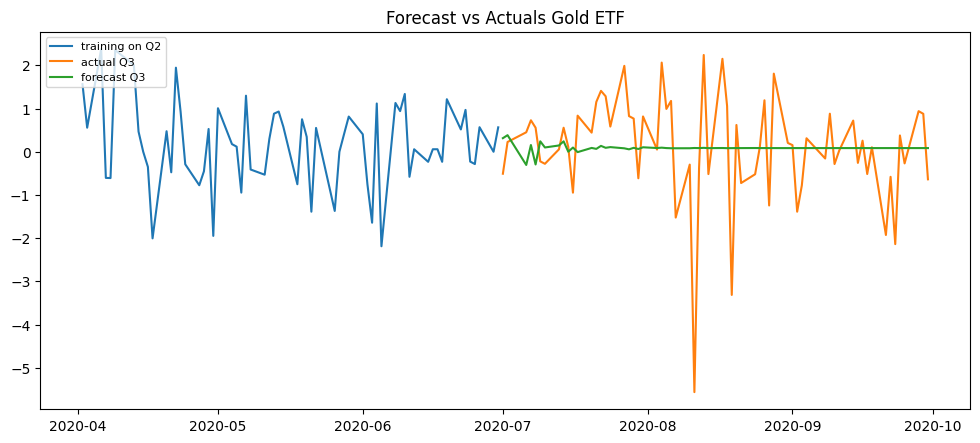

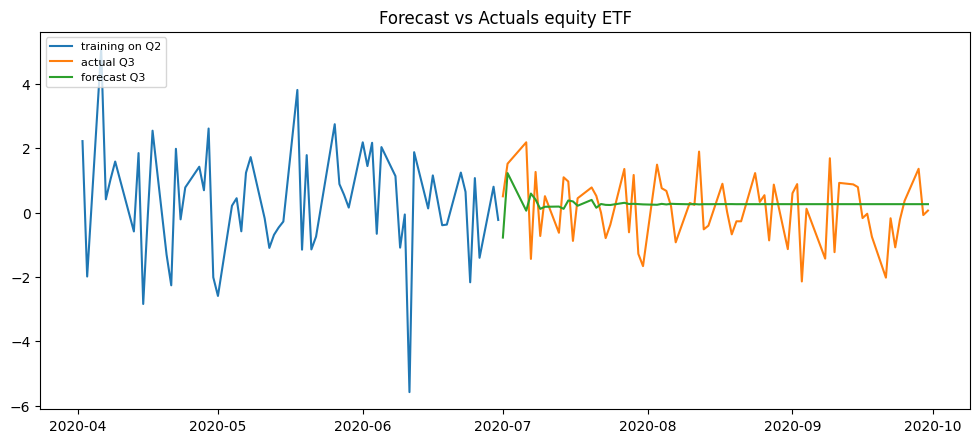

In [ ]:
# PLot actual Vs forecast
plt.figure(figsize=(12,5), dpi=100)
plt.plot(gold_equity_q2['gold_log_return'], label='training on Q2') #This is the training data: Q2
plt.plot(gold_equity_q3['gold_log_return'], label='actual Q3') #This is the test data : Q3
plt.plot(df_q3_forecast['gold_log_return_fc'], label='forecast Q3') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals Gold ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

plt.figure(figsize=(12,5), dpi=100)
plt.plot(gold_equity_q2['equity_log_return'], label='training on Q2') #This is the training data: Q2
plt.plot(gold_equity_q3['equity_log_return'], label='actual Q3') #This is the test data : Q3
plt.plot(df_q3_forecast['equity_log_return_fc'], label='forecast Q3') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals equity ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
import math
from statistics import mean

rmse_gold_q2 = math.sqrt(mean_squared_error(df_q3_forecast['gold_log_return_fc'], gold_equity_q3['gold_log_return']))
print('Root Mean Squared Error for Gold is :{}'.format(rmse_gold_q2))

rmse_equity_q2 = math.sqrt(mean_squared_error(df_q3_forecast['equity_log_return_fc'], gold_equity_q3['equity_log_return']))
print('Root Mean Squared Error for Equity is :{}'.format(rmse_equity_q2))

#rmse_gold_q2 = math.sqrt(mean_squared_error(prediction['gold_q3_predicted'], test_gold_equity_q2['gold_log_return']))
#print('Mean value of gold_returns_q2 is : {}. Root Mean Squared Error is :{}'.format(mean(test_gold_equity_q2['gold_log_return']), rmse_gold_q2))
#rmse_equity_q2 = math.sqrt(mean_squared_error(prediction['equity_q3_predicted'], test_gold_equity_q2['equity_log_return']))
#print('Mean value of equity_returns_q2 is : {}. Root Mean Squared Error is :{}'.format(mean(test_gold_equity_q2['equity_log_return']), rmse_equity_q2))

Root Mean Squared Error for Gold is :1.2554610448204246
Root Mean Squared Error for Equity is :1.0008468690984742


The equity prediction is good in the first few days. The model does not predict the variance long term but predicts the mean.

The gold prediction from teh VAR model has higher root mean squared error and does not predict the Q3 values

In [ ]:
"""
# Training Q2 and testing on Q3(VAR)
gold_equity_q2 = gold_equity_q2[['gold_log_return', 'equity_log_return']]
#print(gold_equity_q2.shape)


train_gold_equity_q2 = gold_equity_q2[:-6]
test_gold_equity_q2 = gold_equity_q2[-6:]
#print(test_gold_equity_q2.shape)

gold_equity_q2_var = VAR(train_gold_equity_q2.diff()[1:])
gold_equity_q2_var = gold_equity_q2_var.select_order(maxlags=6)
print(gold_equity_q2_var.summary())

# Fitting the data(VAR q2)
gold_equity_q2_fitted = VARMAX(train_gold_equity_q2, order=(6,0), enforce_stationarity= True)
fitted_var_q2 = gold_equity_q2_fitted.fit(disp=False)
print(fitted_var_q2.summary())

# Forecasting the data(from VAR q2)
n_forecast = 6
predict_q3 = fitted_var_q2.get_prediction(start=len(train_gold_equity_q2), end=len(train_gold_equity_q2)+ n_forecast-1)

prediction=predict_q3.predicted_mean


prediction.columns=['gold_q3_predicted', 'equity_q3_predicted']
prediction

# Plot
test_vs_pred = pd.concat([test_gold_equity_q2, prediction], axis=1)
test_vs_pred.plot(figsize=(10,6))

# Plot
#plt.figure(figsize=(12,5), dpi=100)
#plt.plot(gold_equity_q2['gold_log_return'], label='training on Q2') #This is the training data: Q2
#plt.plot(gold_equity_q3['gold_log_return'], label='actual Q3') #This is the test data : Q3
#plt.plot(prediction['gold_q2_predicted'], label='forecast Q3') # This is the forecasted Q3 from the VAR model
#plt.title('Forecast vs Actuals')
#plt.legend(loc='upper left', fontsize=8)
#plt.show()
"""



"\n# Training Q2 and testing on Q3(VAR)\ngold_equity_q2 = gold_equity_q2[['gold_log_return', 'equity_log_return']]\n#print(gold_equity_q2.shape)\n\n\ntrain_gold_equity_q2 = gold_equity_q2[:-6]\ntest_gold_equity_q2 = gold_equity_q2[-6:] \n#print(test_gold_equity_q2.shape)\n\ngold_equity_q2_var = VAR(train_gold_equity_q2.diff()[1:])\ngold_equity_q2_var = gold_equity_q2_var.select_order(maxlags=6)\nprint(gold_equity_q2_var.summary())\n\n# Fitting the data(VAR q2)\ngold_equity_q2_fitted = VARMAX(train_gold_equity_q2, order=(6,0), enforce_stationarity= True)\nfitted_var_q2 = gold_equity_q2_fitted.fit(disp=False)\nprint(fitted_var_q2.summary())\n\n# Forecasting the data(from VAR q2)\nn_forecast = 6\npredict_q3 = fitted_var_q2.get_prediction(start=len(train_gold_equity_q2), end=len(train_gold_equity_q2)+ n_forecast-1) \n\nprediction=predict_q3.predicted_mean\n\n\nprediction.columns=['gold_q3_predicted', 'equity_q3_predicted']\nprediction\n\n# Plot\ntest_vs_pred = pd.concat([test_gold_equity_q

###VAR on Q3 to forecast Q4

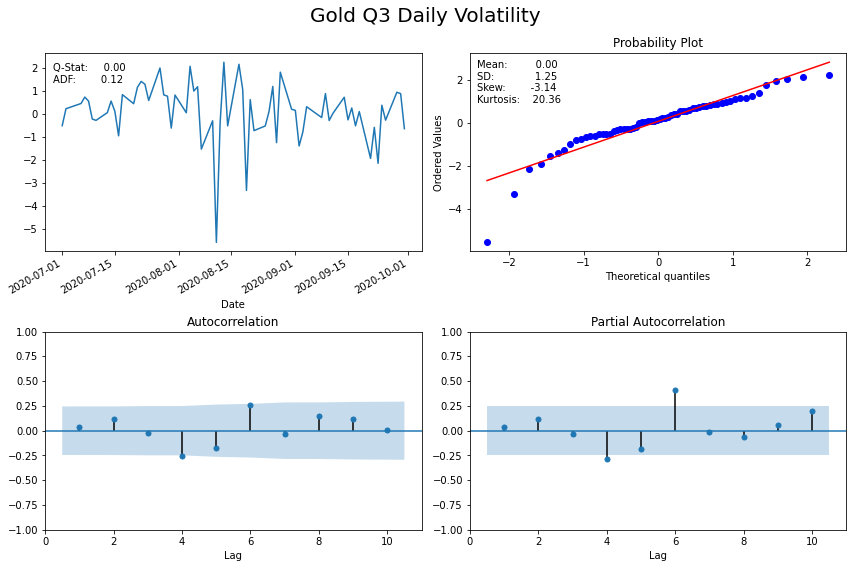

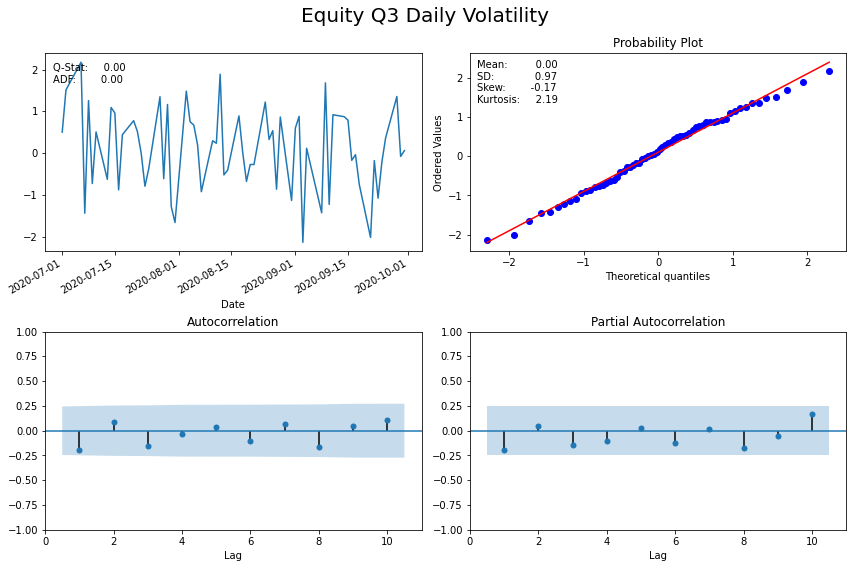

In [ ]:
# Visualizing the returns and log returns, log_returns(down)
plot_correlogram(gold_equity_q3['gold_log_return'], lags=10, title='Gold Q3 Daily Volatility')
plot_correlogram(gold_equity_q3['equity_log_return'], lags=10, title='Equity Q3 Daily Volatility')

In [ ]:
coint(gold_equity_q3, 'gold_log_return', 'equity_log_return')

p-value:  0.28516724976281727
gold_log_return: Null hypothesis is true. Co-Integration does not exist


In [ ]:
q3_varmodel = VAR(gold_equity_q3[['gold_log_return','equity_log_return']])
#q2_aic_var = q2_varmodel.select_order(maxlags=8)
#print(q2_aic_var.summary())
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = q3_varmodel.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  0.44544485897351854
BIC :  0.6495529281536645
FPE :  1.561409639179518
HQIC:  0.5257215602323109 

Lag Order = 2
AIC :  0.5371197386961739
BIC :  0.880205929832479
FPE :  1.7122731181881998
HQIC:  0.6718240330978572 

Lag Order = 3
AIC :  0.5461051965183623
BIC :  1.0305680505909256
FPE :  1.7300254515834286
HQIC:  0.7359707292722871 

Lag Order = 4
AIC :  0.5877762946131713
BIC :  1.2160796632798014
FPE :  1.8082111440394888
HQIC:  0.8335402824705428 

Lag Order = 5
AIC :  0.6806366375677965
BIC :  1.4553116166512852
FPE :  1.9926439758874246
HQIC:  0.9830383747733379 

Lag Order = 6
AIC :  0.6317611330309081
BIC :  1.5554079998275787
FPE :  1.9102692170004425
HQIC:  0.9915402424286925 

Lag Order = 7
AIC :  0.7709133517442398
BIC :  1.846203492709793
FPE :  2.217265709244895
HQIC:  1.188807742502107 

Lag Order = 8
AIC :  0.8751000617429894
BIC :  2.1047778739750447
FPE :  2.495801543411053
HQIC:  1.351843549012333 

Lag Order = 9
AIC :  0.9667646844159148
BIC : 

Lag 5 and 10 serves as a line of minimum values . We use lag 10 to capture lon term variability

In [ ]:
print('Testing stationarity in Gold etf q3')
stn_test(gold_equity_q3['gold_log_return'])
print('-------------------------------------')
print('Testing stationarity in Gold etf q3')
stn_test(gold_equity_q3['gold_log_return'].diff().dropna())
print('-------------------------------------')
print('Testing stationarity in Equity etf q3')
stn_test(gold_equity_q3['equity_log_return'])

Testing stationarity in Gold etf q3
ADF Statistic: -2.491235
p-value: 0.117621
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594
-------------------------------------
Testing stationarity in Gold etf q3
ADF Statistic: -7.965018
p-value: 0.000000
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594
-------------------------------------
Testing stationarity in Equity etf q3
ADF Statistic: -9.534626
p-value: 0.000000
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


Gold ETF is not stationary in Q3 but the difference is stationary

In [ ]:
gold_equity_q3 = gold_equity_q3.diff().dropna()

In [ ]:
q3_varmodel = VAR(gold_equity_q3[['gold_log_return','equity_log_return']])
q3_varmodel_fitted = q3_varmodel.fit(10)
q3_varmodel_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Feb, 2022
Time:                     17:34:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.42415
Nobs:                     53.0000    HQIC:                   1.46321
Log likelihood:          -131.271    FPE:                    2.59748
AIC:                     0.862789    Det(Omega_mle):         1.33242
--------------------------------------------------------------------
Results for equation gold_log_return
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.094360         0.187219           -0.504           0.614
L1.gold_log_return           -0.829805         0.175969           -4.716           0.000
L1.equity_log_retu

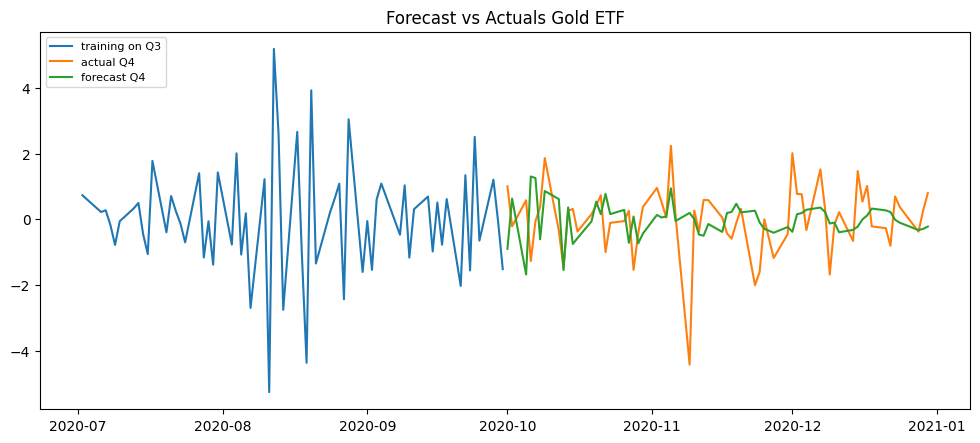

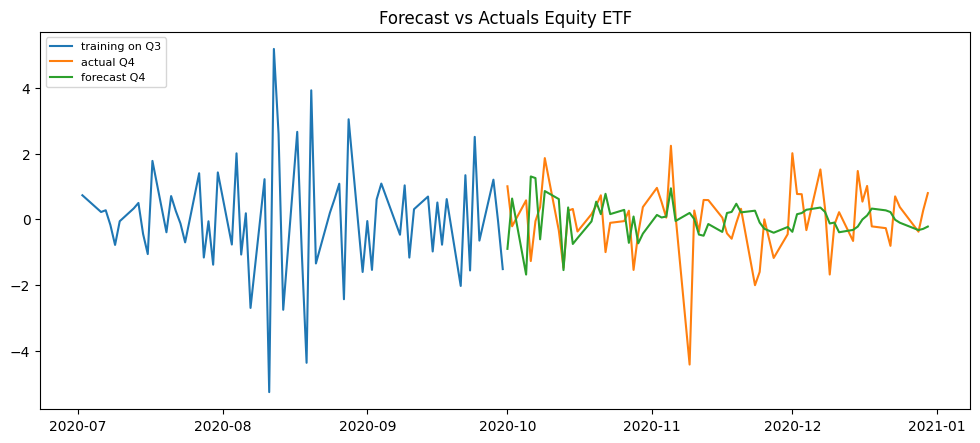

In [ ]:
# Forecasting the data(from VAR q2)
# Get the lag order
lag_order = q3_varmodel_fitted.k_ar

# Input data for forecasting
forecast_input = gold_equity_q3[['gold_log_return','equity_log_return']].values[-lag_order:]

q4_fc = q3_varmodel_fitted.forecast(y=forecast_input, steps=len(gold_equity_q4))

df_q4_forecast = pd.DataFrame(q4_fc, index=gold_equity_q4.index, columns=['gold_log_return_fc','equity_log_return_fc'])

# PLot actual Vs forecast
plt.figure(figsize=(12,5), dpi=100)
plt.plot(gold_equity_q3['gold_log_return'], label='training on Q3') #This is the training data: Q2
plt.plot(gold_equity_q4['gold_log_return'], label='actual Q4') #This is the test data : Q3
plt.plot(df_q4_forecast['gold_log_return_fc'], label='forecast Q4') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals Gold ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

plt.figure(figsize=(12,5), dpi=100)
plt.plot(gold_equity_q3['gold_log_return'], label='training on Q3') #This is the training data: Q2
plt.plot(gold_equity_q4['gold_log_return'], label='actual Q4') #This is the test data : Q3
plt.plot(df_q4_forecast['gold_log_return_fc'], label='forecast Q4') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals Equity ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
rmse_gold_q3 = math.sqrt(mean_squared_error(df_q4_forecast['gold_log_return_fc'], gold_equity_q4['gold_log_return']))
print('Root Mean Squared Error for Gold is :{}'.format(rmse_gold_q3))

rmse_equity_q3 = math.sqrt(mean_squared_error(df_q4_forecast['equity_log_return_fc'], gold_equity_q4['equity_log_return']))
print('Root Mean Squared Error for Equity is :{}'.format(rmse_equity_q2))


Root Mean Squared Error for Gold is :1.1572816955073293
Root Mean Squared Error for Equity is :1.0008468690984742


The VAR model trained on Q3 with lag=10 gives a good prediction on Gold and Equity ETF on Q4.

# Performing the multivariate GARCH

In [ ]:
! pip install mgarch

  Created wheel for mgarch: filename=mgarch-0.2.0-py3-none-any.whl size=3379 sha256=72f1ae4ff881b5c808d8be61544f8b27b9b2c5602856571ae9d853c80a1b2e77
  Stored in directory: /root/.cache/pip/wheels/70/04/0f/902fe872c7729649f8aa41c1e07c685085fdfdc5ddc6407d7d
Successfully built mgarch


In [ ]:
import mgarch

dcc_garch_q2 = mgarch.mgarch('t')
#dcc_garch_q2.fit(gold_equity_q2[['gold_log_return', 'equity_log_return']].to_numpy())
#ndays = len(gold_equity_q3)
#garch_q3_fc = dcc_garch_q2.predict(ndays)

We tried to run multivariate GARCH model. However, there is no standard package for this in python unlike R.
We got an error while running the above code which we could not fix due to lacking documentation.

## VECM model
We can run VECM model which imposes additional restriction due to the existence of non-stationary but co-integrated data forms.

Johansen test for cointegration

The null hypothesis was that the time series are not cointegrated. When we reject the null hypothesis, we suggest that the series are cointegrated.

The trace statistics tells us if the sum of the eigenvalues is 0. If the null hypothesis i.e. r<=0 has a trace statistic greater than the trace critical values, the null hypothesis can be rejected at a that confidence level (90%, 95% or 99%). The eigen statistics stores the eigenvalues in decreasing order of magnitude. This gives us information about how strongly cointegrated the series are or how strong is the tendency to mean revert. If the eigen statistic for the null hypothesis is greater than the critical values, null hypothesis can be rejected at that confidence level.

In [ ]:
# Cointegration test
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM

def johansen(df, det_order, k_ar_diff):
  jres = coint_johansen(df, det_order=det_order, k_ar_diff=k_ar_diff)
  print('Trace statistic for r <= 0: ', jres.trace_stat[0])
  print('Trace critical values for r <= 0: ',jres.trace_stat_crit_vals[0])
  print('Eigen statistic for r <= 0: ', jres.max_eig_stat[0])
  print('Eigen critical values for r <= 0: ',jres.max_eig_stat_crit_vals[0])

# 'gold_log_return', 'equity_log_return' Q2
#jh_result = coint_johansen(gold_equity_q2, 0, 1)
#print(jh_result.lr1)
#print(jh_result.cvt)
#print(jh_result.evec)
#v1 = jh_result.evec[:, 0]
#v2 = jh_result.evec[:, 1]

In [ ]:
# Q2
johansen(gold_equity_q2[['gold_log_return', 'equity_log_return']].values, det_order=0, k_ar_diff=1)

Trace statistic for r <= 0:  53.98598962769675
Trace critical values for r <= 0:  [13.4294 15.4943 19.9349]
Eigen statistic for r <= 0:  28.36249157499871
Eigen critical values for r <= 0:  [12.2971 14.2639 18.52  ]


In [ ]:
# Q3
johansen(gold_equity_q2[['gold_log_return', 'equity_log_return']].values, det_order=0, k_ar_diff=1)

Trace statistic for r <= 0:  53.98598962769675
Trace critical values for r <= 0:  [13.4294 15.4943 19.9349]
Eigen statistic for r <= 0:  28.36249157499871
Eigen critical values for r <= 0:  [12.2971 14.2639 18.52  ]


The trace statistic and eigen statistic is greater than the critical values. Hence, we can reject the null hypothesis with 99% confidence.

Gold and Equity Q2: Co-Integration exists
Gold and Equity Q3: Co-Integration exists

However, we also need to cehck the condition of stationarity. In Q2, gold and ETF are stationary from ADF test. In Q3, gold is not stationary while Equity is.

We run VECM model on Q3 data


In [ ]:
vecm = VECM(endog = gold_equity_q3[['gold_log_return', 'equity_log_return']], k_ar_diff = 9, coint_rank = 3, deterministic = 'ci')
vecm_fit = vecm.fit()
vecm_predict = vecm_fit.predict(steps=len(gold_equity_q4))

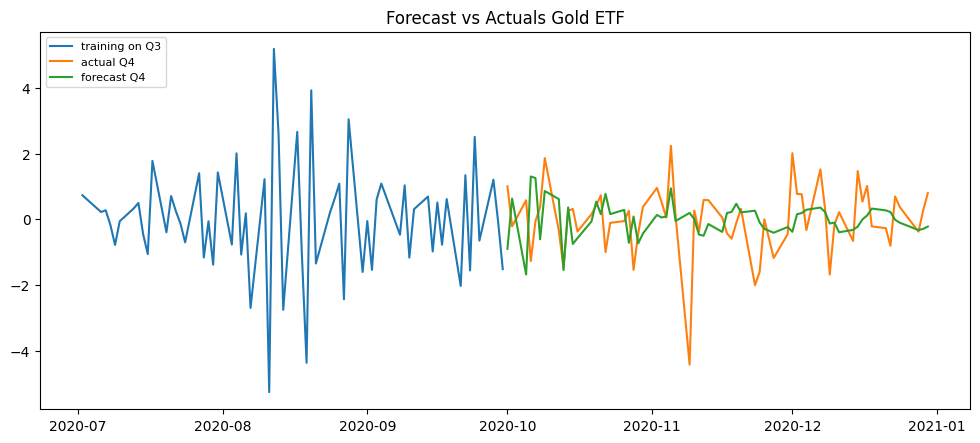

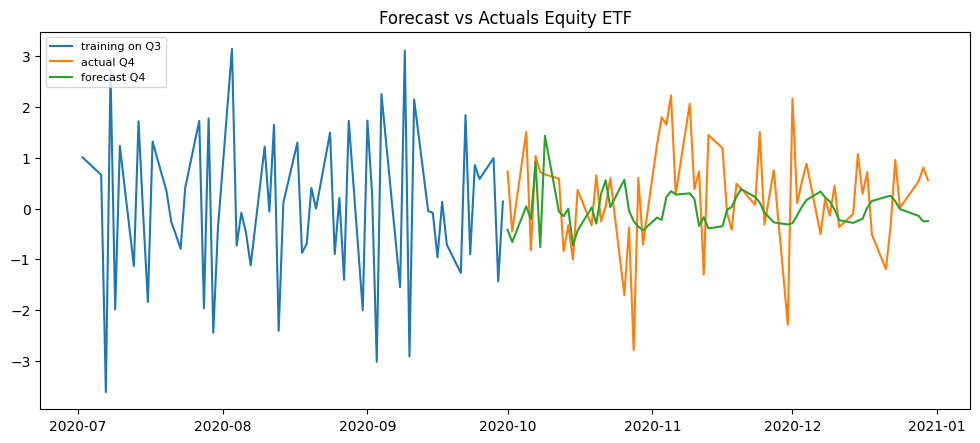

In [ ]:
vecm_q4_forecast = pd.DataFrame(vecm_predict, index=gold_equity_q4.index, columns=['gold_log_return_fc','equity_log_return_fc'])

# PLot actual Vs forecast
plt.figure(figsize=(12,5), dpi=100)
plt.plot(gold_equity_q3['gold_log_return'], label='training on Q3') #This is the training data: Q2
plt.plot(gold_equity_q4['gold_log_return'], label='actual Q4') #This is the test data : Q3
plt.plot(vecm_q4_forecast ['gold_log_return_fc'], label='forecast Q4') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals Gold ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

plt.figure(figsize=(12,5), dpi=100)
plt.plot(gold_equity_q3['equity_log_return'], label='training on Q3') #This is the training data: Q2
plt.plot(gold_equity_q4['equity_log_return'], label='actual Q4') #This is the test data : Q3
plt.plot(vecm_q4_forecast ['equity_log_return_fc'], label='forecast Q4') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals Equity ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
q3_vecm_rmse_gold = math.sqrt(mean_squared_error(vecm_q4_forecast ['gold_log_return_fc'], gold_equity_q4['gold_log_return']))
print('Root Mean Squared Error for Gold is :{}'.format(q3_vecm_rmse_gold))

q3_vecm_rmse_equity = math.sqrt(mean_squared_error(vecm_q4_forecast ['equity_log_return_fc'], gold_equity_q4['equity_log_return']))
print('Root Mean Squared Error for Gold is :{}'.format(q3_vecm_rmse_equity))

Root Mean Squared Error for Gold is :1.1572816955070981
Root Mean Squared Error for Gold is :1.0511458723828258


We run ARIMA, GARCH, VAR and VECM models on Q3 and on Q2 (where applicable).

The VAR and VECM models give similar prediction results and are better than the ARMA and GARCH models.
These models predict the volatility of the gold and equity ETFs.

# 7. Category 3 Models

## VAR

Training Q2 and testing on Q3

In [ ]:
all_q2 = pd.concat([gold_etf_q2[['gold_returns', 'gold_log_return']], equity_etf_q2[['equity_returns', 'equity_log_return']], bitcoin_q2[['bitcoin_returns', 'bitcoin_log_return']]], axis=1).reindex(gold_etf_q2.index)
all_q3 = pd.concat([gold_etf_q3[['gold_returns', 'gold_log_return']], equity_etf_q3[['equity_returns', 'equity_log_return']], bitcoin_q3[['bitcoin_returns', 'bitcoin_log_return']]], axis=1).reindex(gold_etf_q3.index)
all_q4 = pd.concat([gold_etf_q4[['gold_returns', 'gold_log_return']], equity_etf_q4[['equity_returns', 'equity_log_return']], bitcoin_q4[['bitcoin_returns', 'bitcoin_log_return']]], axis=1).reindex(gold_etf_q4.index)


In [ ]:

all_q2 = all_q2[['gold_log_return', 'equity_log_return', 'bitcoin_log_return']]
all_q3 = all_q3[['gold_log_return', 'equity_log_return', 'bitcoin_log_return']]
all_q4 = all_q4[['gold_log_return', 'equity_log_return', 'bitcoin_log_return']]

In [ ]:
allq2_varmodel = VAR(all_q2)
allq2_aic_var = allq2_varmodel.select_order(maxlags=8)
print(allq2_aic_var.summary())
for i in [1,2,3,4,5,6,7,8,9, 10, 11, 12, 13 ,14]:
    result = allq2_varmodel.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      2.972*      3.082*      19.53*      3.014*
1       3.166       3.608       23.72       3.336
2       3.426       4.199       30.88       3.724
3       3.607       4.712       37.35       4.034
4       3.672       5.108       40.47       4.226
5       3.771       5.539       45.89       4.453
6       3.745       5.845       46.49       4.555
7       3.748       6.179       49.31       4.685
8       3.928       6.691       63.88       4.994
-------------------------------------------------
Lag Order = 1
AIC :  3.3804079077719074
BIC :  3.7956617826912473
FPE :  29.399371336517042
HQIC:  3.5431497929895572 

Lag Order = 2
AIC :  3.6591947139626058
BIC :  4.39221531074034
FPE :  38.954598675827306
HQIC:  3.9459193664628724 

Lag Order = 3
AIC :  3.7147027357807447
BIC :  4.771077707258229
FPE :  41.45515343063174
HQIC:  4.1270687410610

Lag = 14 has the minimum AIC

In [ ]:
allq2_varmodel = VAR(all_q2)
allq2_varmodel_fitted = allq2_varmodel .fit(14)
allq2_varmodel_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Feb, 2022
Time:                     17:34:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    5.33835
Nobs:                     48.0000    HQIC:                   2.20991
Log likelihood:          -82.7551    FPE:                    38.0447
AIC:                     0.309497    Det(Omega_mle):         5.58334
--------------------------------------------------------------------
Results for equation gold_log_return
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.552314         0.616685            0.896           0.370
L1.gold_log_return            -0.019006         0.389743           -0.049           0.961
L1.equity_log_

In [ ]:
# Forecasting the data(from VAR q2)
# Get the lag order
lag_order = allq2_varmodel_fitted.k_ar
#print(lag_order)  #> 4

# Input data for forecasting
forecast_input = all_q2.values[-lag_order:]
#forecast_input

# Forecast
allq3_fc = allq2_varmodel_fitted.forecast(y=forecast_input, steps=len(all_q3))

alldf_q3_forecast = pd.DataFrame(allq3_fc, index=all_q3.index, columns=['gold_log_return_fc','equity_log_return_fc','bitcoin_log_return_fc'])
#alldf_q3_forecast.head()

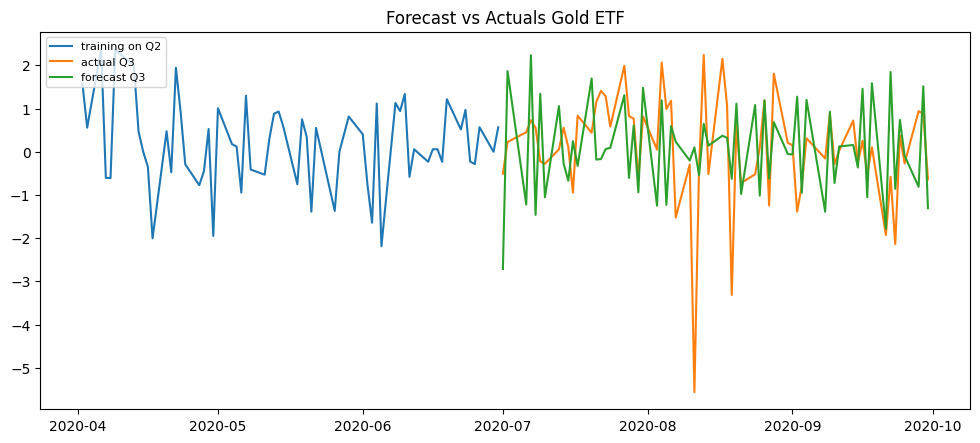

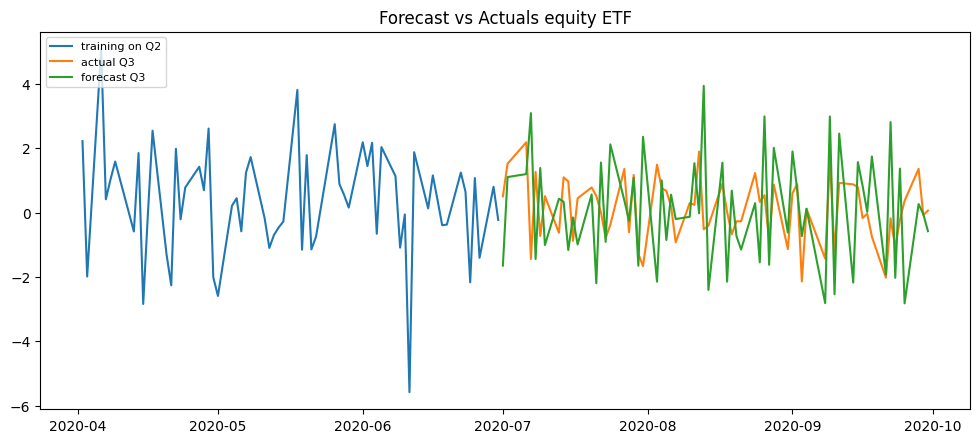

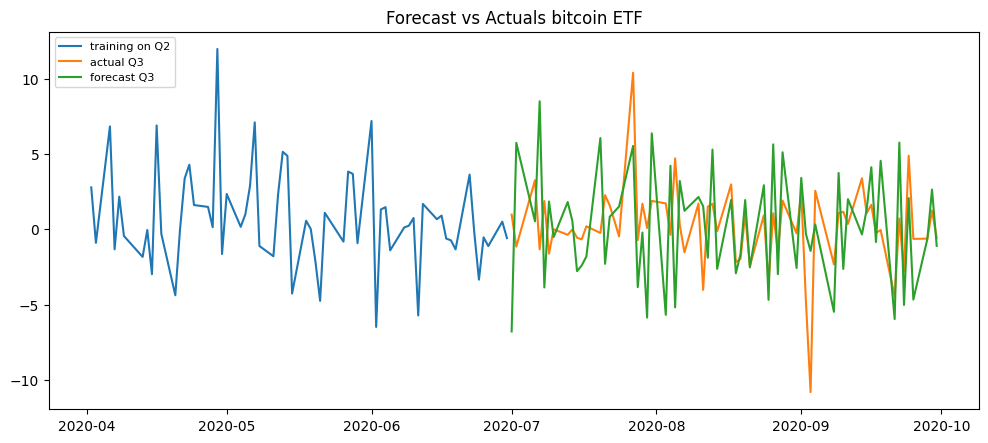

In [ ]:
# Plot actual Vs forecast
plt.figure(figsize=(12,5), dpi=100)
plt.plot(all_q2['gold_log_return'], label='training on Q2') #This is the training data: Q2
plt.plot(all_q3['gold_log_return'], label='actual Q3') #This is the test data : Q3
plt.plot(alldf_q3_forecast['gold_log_return_fc'], label='forecast Q3') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals Gold ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

plt.figure(figsize=(12,5), dpi=100)
plt.plot(all_q2['equity_log_return'], label='training on Q2') #This is the training data: Q2
plt.plot(all_q3['equity_log_return'], label='actual Q3') #This is the test data : Q3
plt.plot(alldf_q3_forecast['equity_log_return_fc'], label='forecast Q3') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals equity ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

plt.figure(figsize=(12,5), dpi=100)
plt.plot(all_q2['bitcoin_log_return'], label='training on Q2') #This is the training data: Q2
plt.plot(all_q3['bitcoin_log_return'], label='actual Q3') #This is the test data : Q3
plt.plot(alldf_q3_forecast['bitcoin_log_return_fc'], label='forecast Q3') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals bitcoin ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
var_rmse_gold_q2 = math.sqrt(mean_squared_error(alldf_q3_forecast['gold_log_return_fc'], all_q3['gold_log_return']))
print('Root Mean Squared Error for Gold is :{}'.format(var_rmse_gold_q2))

var_rmse_equity_q2 = math.sqrt(mean_squared_error(alldf_q3_forecast['equity_log_return_fc'], all_q3['equity_log_return']))
print('Root Mean Squared Error for Equity is :{}'.format(var_rmse_equity_q2))

var_rmse_bitcoin_q2 = math.sqrt(mean_squared_error(alldf_q3_forecast['bitcoin_log_return_fc'], all_q3['bitcoin_log_return']))
print('Root Mean Squared Error for Equity is :{}'.format(var_rmse_bitcoin_q2))

Root Mean Squared Error for Gold is :1.3904141195629198
Root Mean Squared Error for Equity is :1.7718634061251037
Root Mean Squared Error for Equity is :3.9107382126383183


## VAR : Training on Q3 and test on Q4

In [ ]:
allq3_varmodel = VAR(all_q3)
#allq2_aic_var = allq2_varmodel.select_order(maxlags=8)
#print(allq2_aic_var.summary())
for i in [1,2,3,4,5,6,7,8,9,11,12,13,14]:
    result = allq3_varmodel.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  2.0609086041371745
BIC :  2.4691247424974665
FPE :  7.857132748647314
HQIC:  2.2214620066547592 

Lag Order = 2
AIC :  2.164766864069057
BIC :  2.8852478654552978
FPE :  8.737878864158475
HQIC:  2.447645882312592 

Lag Order = 3
AIC :  2.2620719780139287
BIC :  3.3002066653122784
FPE :  9.689357842548196
HQIC:  2.6689266910580534 

Lag Order = 4
AIC :  2.40329773637748
BIC :  3.764621701821845
FPE :  11.29356680933996
HQIC:  2.935786376735118 

Lag Order = 5
AIC :  2.630460607010098
BIC :  4.320660561374073
FPE :  14.471858296333679
HQIC:  3.2902462154585517 

Lag Order = 6
AIC :  2.716617813243432
BIC :  4.741535944297672
FPE :  16.31087232132473
HQIC:  3.505364322307806 

Lag Order = 7
AIC :  2.79499681329296
BIC :  5.160635123417176
FPE :  18.56924490672833
HQIC:  3.7143644729602676 

Lag Order = 8
AIC :  3.1031840743546857
BIC :  5.8157086601606895
FPE :  27.27576274583905
HQIC:  4.154824119801767 

Lag Order = 9
AIC :  3.1842469142391012
BIC :  6.2499921425941

Lag = 13 has a low AIC score

In [ ]:
allq3_varmodel = VAR(all_q3)
allq3_varmodel_fitted = allq3_varmodel .fit(13)
allq3_varmodel_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Feb, 2022
Time:                     17:34:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    6.64300
Nobs:                     51.0000    HQIC:                   3.83449
Log likelihood:          -150.585    FPE:                    41.7017
AIC:                      2.09753    Det(Omega_mle):         7.34075
--------------------------------------------------------------------
Results for equation gold_log_return
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -0.191880         0.263756           -0.727           0.467
L1.gold_log_return             0.266571         0.310642            0.858           0.391
L1.equity_log_

In [ ]:
# Forecasting the data(from VAR q2)
lag_order = allq3_varmodel_fitted.k_ar
forecast_input = all_q3.values[-lag_order:]
# Forecast
allq4_fc = allq3_varmodel_fitted.forecast(y=forecast_input, steps=len(all_q4))
alldf_q4_forecast = pd.DataFrame(allq4_fc, index=all_q4.index, columns=['gold_log_return_fc','equity_log_return_fc','bitcoin_log_return_fc'])
#alldf_q3_forecast.head()

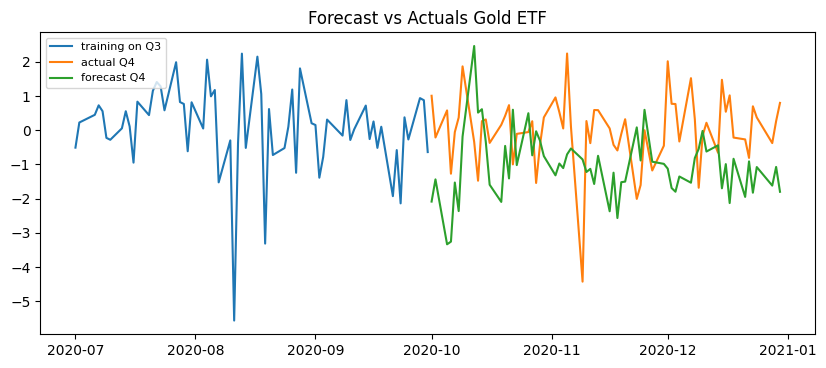

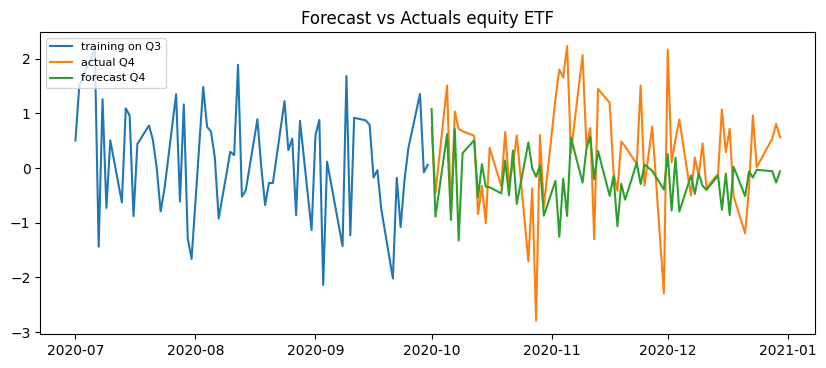

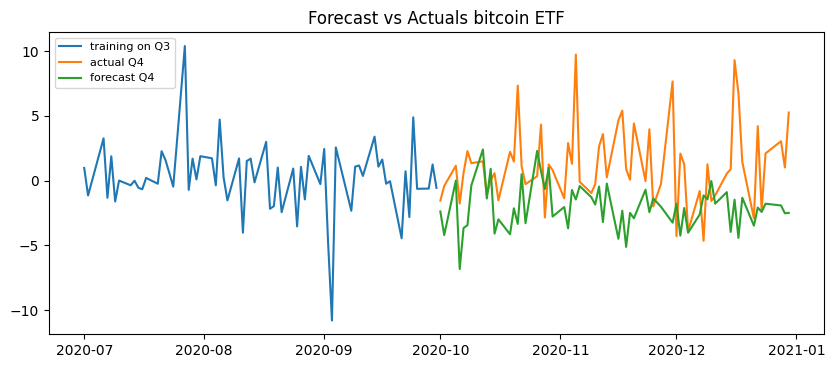

In [ ]:
# Plot actual Vs forecast
plt.figure(figsize=(10,4), dpi=100)
plt.plot(all_q3['gold_log_return'], label='training on Q3') #This is the training data: Q2
plt.plot(all_q4['gold_log_return'], label='actual Q4') #This is the test data : Q3
plt.plot(alldf_q4_forecast['gold_log_return_fc'], label='forecast Q4') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals Gold ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

plt.figure(figsize=(10,4), dpi=100)
plt.plot(all_q3['equity_log_return'], label='training on Q3') #This is the training data: Q2
plt.plot(all_q4['equity_log_return'], label='actual Q4') #This is the test data : Q3
plt.plot(alldf_q4_forecast['equity_log_return_fc'], label='forecast Q4') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals equity ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

plt.figure(figsize=(10,4), dpi=100)
plt.plot(all_q3['bitcoin_log_return'], label='training on Q3') #This is the training data: Q2
plt.plot(all_q4['bitcoin_log_return'], label='actual Q4') #This is the test data : Q3
plt.plot(alldf_q4_forecast['bitcoin_log_return_fc'], label='forecast Q4') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals bitcoin ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
var_rmse_gold_q3 = math.sqrt(mean_squared_error(alldf_q4_forecast['gold_log_return_fc'], all_q4['gold_log_return']))
print('Root Mean Squared Error for Gold is :{}'.format(var_rmse_gold_q3))

var_rmse_equity_q3 = math.sqrt(mean_squared_error(alldf_q4_forecast['equity_log_return_fc'], all_q4['equity_log_return']))
print('Root Mean Squared Error for Equity is :{}'.format(var_rmse_equity_q3))

var_rmse_bitcoin_q3 = math.sqrt(mean_squared_error(alldf_q4_forecast['bitcoin_log_return_fc'], all_q4['bitcoin_log_return']))
print('Root Mean Squared Error for Bitcoin is :{}'.format(var_rmse_bitcoin_q3))

Root Mean Squared Error for Gold is :1.8620047106175046
Root Mean Squared Error for Equity is :1.160324834538318
Root Mean Squared Error for Bitcoin is :4.8442651198462725


## Cointegration and vector error correction model (VECM)

We have seen previously that

Gold and Equity Q2: Co-Integration exists

Gold and Equity Q3: Co-Integration exists

In [ ]:
print('Q2 gold and bitcoin')
johansen(all_q2[['gold_log_return', 'bitcoin_log_return']].values, det_order=0, k_ar_diff=1)
print('---------------------')
print('Q2 equity and bitcoin')
johansen(all_q2[['equity_log_return', 'bitcoin_log_return']].values, det_order=0, k_ar_diff=1)
print('---------------------')
print('Q3 gold and bitcoin')
johansen(all_q3[['gold_log_return', 'bitcoin_log_return']].values, det_order=0, k_ar_diff=1)
print('---------------------')
print('Q3 equity and bitcoin')
johansen(all_q3[['equity_log_return', 'bitcoin_log_return']].values, det_order=0, k_ar_diff=1)

Q2 gold and bitcoin
Trace statistic for r <= 0:  51.418719637320294
Trace critical values for r <= 0:  [13.4294 15.4943 19.9349]
Eigen statistic for r <= 0:  32.34532432786801
Eigen critical values for r <= 0:  [12.2971 14.2639 18.52  ]
---------------------
Q2 equity and bitcoin
Trace statistic for r <= 0:  55.68020968513228
Trace critical values for r <= 0:  [13.4294 15.4943 19.9349]
Eigen statistic for r <= 0:  28.61871228155926
Eigen critical values for r <= 0:  [12.2971 14.2639 18.52  ]
---------------------
Q3 gold and bitcoin
Trace statistic for r <= 0:  48.31382676956463
Trace critical values for r <= 0:  [13.4294 15.4943 19.9349]
Eigen statistic for r <= 0:  29.548315446101828
Eigen critical values for r <= 0:  [12.2971 14.2639 18.52  ]
---------------------
Q3 equity and bitcoin
Trace statistic for r <= 0:  61.152062836400845
Trace critical values for r <= 0:  [13.4294 15.4943 19.9349]
Eigen statistic for r <= 0:  39.56490620308173
Eigen critical values for r <= 0:  [12.2971 

Cointegration exists between all the three returns

In [ ]:
print('Q2 gold, equity and bitcoin')
johansen(all_q2[['gold_log_return','equity_log_return', 'bitcoin_log_return']].values, det_order=0, k_ar_diff=1)
print('---------------------')
print('Q3 gold, equity and bitcoin')
johansen(all_q3[['gold_log_return','equity_log_return', 'bitcoin_log_return']].values, det_order=0, k_ar_diff=1)

Q2 gold, equity and bitcoin
Trace statistic for r <= 0:  79.0996344726347
Trace critical values for r <= 0:  [27.0669 29.7961 35.4628]
Eigen statistic for r <= 0:  33.611382061683116
Eigen critical values for r <= 0:  [18.8928 21.1314 25.865 ]
---------------------
Q3 gold, equity and bitcoin
Trace statistic for r <= 0:  90.47300459584791
Trace critical values for r <= 0:  [27.0669 29.7961 35.4628]
Eigen statistic for r <= 0:  42.190821587977645
Eigen critical values for r <= 0:  [18.8928 21.1314 25.865 ]


## VECM model train on Q3 and predict on Q4

In [ ]:
allq3_vecm = VECM(endog = all_q3[['gold_log_return', 'equity_log_return','bitcoin_log_return']], k_ar_diff = 9, coint_rank = 3, deterministic = 'ci')
allq3_vecm_fit = allq3_vecm.fit()
allq4_vecm_predict = allq3_vecm_fit.predict(steps=len(all_q4))

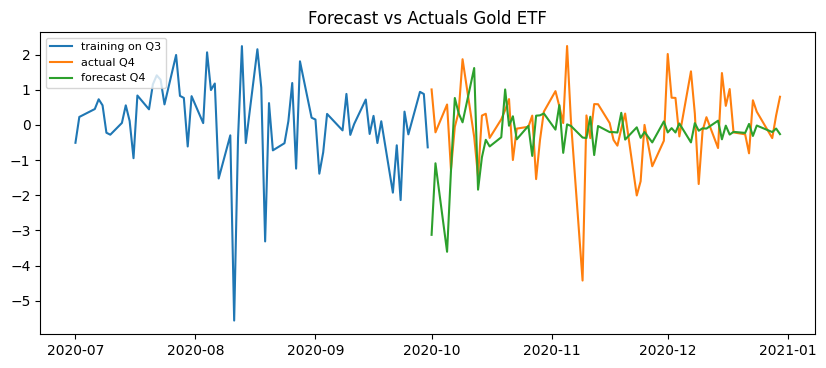

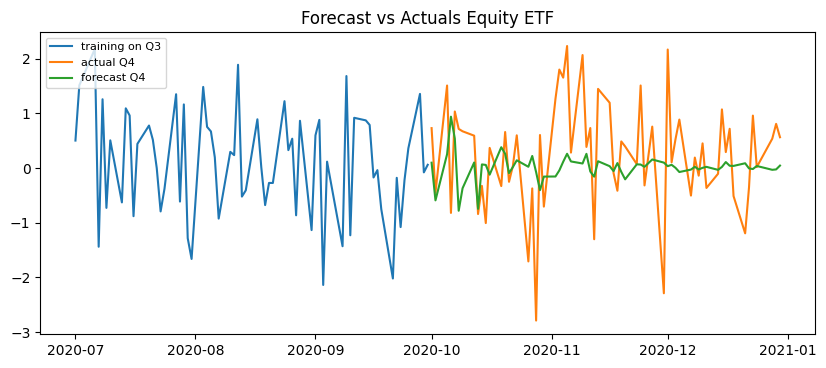

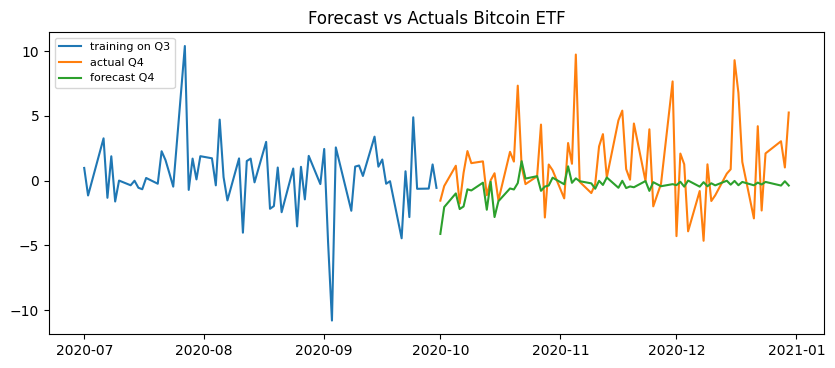

<Figure size 432x288 with 0 Axes>

In [ ]:
allq4_vecm_forecast = pd.DataFrame(allq4_vecm_predict, index=all_q4.index, columns=['gold_log_return_fc','equity_log_return_fc', 'bitcoin_log_return_fc'])

# PLot actual Vs forecast
plt.figure(figsize=(10,4), dpi=100)
plt.plot(all_q3['gold_log_return'], label='training on Q3') #This is the training data: Q2
plt.plot(all_q4['gold_log_return'], label='actual Q4') #This is the test data : Q3
plt.plot(allq4_vecm_forecast['gold_log_return_fc'], label='forecast Q4') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals Gold ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

plt.figure(figsize=(10,4), dpi=100)
plt.plot(all_q3['equity_log_return'], label='training on Q3') #This is the training data: Q2
plt.plot(all_q4['equity_log_return'], label='actual Q4') #This is the test data : Q3
plt.plot(allq4_vecm_forecast['equity_log_return_fc'], label='forecast Q4') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals Equity ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()

plt.figure(figsize=(10,4), dpi=100)
plt.plot(all_q3['bitcoin_log_return'], label='training on Q3') #This is the training data: Q2
plt.plot(all_q4['bitcoin_log_return'], label='actual Q4') #This is the test data : Q3
plt.plot(allq4_vecm_forecast['bitcoin_log_return_fc'], label='forecast Q4') # This is the forecasted Q3 from the VAR model
plt.title('Forecast vs Actuals Bitcoin ETF')
plt.legend(loc='upper left', fontsize=8)
plt.show()
#plt.savefig('VECM.png')

In [ ]:
allq3_vecm_rmse_gold = math.sqrt(mean_squared_error(allq4_vecm_forecast['gold_log_return_fc'], all_q4['gold_log_return']))
print('Root Mean Squared Error for Gold is :{}'.format(allq3_vecm_rmse_gold))

allq3_vecm_rmse_equity = math.sqrt(mean_squared_error(allq4_vecm_forecast['equity_log_return_fc'], all_q4['equity_log_return']))
print('Root Mean Squared Error for Gold is :{}'.format(allq3_vecm_rmse_equity))

allq3_vecm_rmse_bitcoin = math.sqrt(mean_squared_error(allq4_vecm_forecast['bitcoin_log_return_fc'], all_q4['bitcoin_log_return']))
print('Root Mean Squared Error for Gold is :{}'.format(allq3_vecm_rmse_bitcoin))


Root Mean Squared Error for Gold is :1.3194733999888504
Root Mean Squared Error for Gold is :1.0206234144093553
Root Mean Squared Error for Gold is :3.4103760539518095


Among all the models, the error correction model, VECM captures the long term variability